In [630]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.experimental import enable_iterative_imputer  # Import necessary for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier, NearestNeighbors
from sklearn.svm import OneClassSVM


In [573]:
data = pd.read_csv("NBA_df_AllStars.csv")
data.drop('LEAGUE_ID', axis=1, inplace=True)

We will exclude the data of All-Star players beyond 2019, since we do not have information on them.

In [575]:
data = data[data['Year'] <= 2019]

### Handling Missing Values & Data Cleaning

These steps were taken to avoid a scenario where we enter values in the OREB and DREB columns that, when summed, exceed the player's current REB value.

In [577]:
data[(~data['DREB'].isnull()) & data['OREB'].isnull()].iloc[:, 10:]

Empty DataFrame
Columns: [FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, full_name, Year, All_Star]
Index: []

In [578]:
data[(~data['REB'].isnull())&(data['OREB'].isna())&(data['DREB'].isna())].iloc[:, 10:]

FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB    REB  AST  \
9       0.363   NaN   NaN      NaN   68  106   0.642   NaN   NaN  378.0   33   
10      0.419   NaN   NaN      NaN    2    7   0.286   NaN   NaN   31.0    4   
11      0.369   NaN   NaN      NaN   70  113   0.619   NaN   NaN  409.0   37   
12      0.434   NaN   NaN      NaN  119  185   0.643   NaN   NaN  603.0   62   
13      0.441   NaN   NaN      NaN  139  188   0.739   NaN   NaN  468.0   42   
...       ...   ...   ...      ...  ...  ...     ...   ...   ...    ...  ...   
17287   0.348   NaN   NaN      NaN   54   88   0.614   NaN   NaN  155.0  131   
17289   0.340   NaN   NaN      NaN  404  484   0.835   NaN   NaN  495.0  184   
17290   0.361   NaN   NaN      NaN  310  372   0.833   NaN   NaN  434.0  247   
17291   0.334   NaN   NaN      NaN  243  296   0.821   NaN   NaN  413.0  245   
17292   0.388   NaN   NaN      NaN  153  195   0.785   NaN   NaN  267.0  109   

       STL  BLK  TOV   PF   PTS        full_name  Year  All_Star  
9      NaN  NaN  NaN   98   320  Zaid Abdul-Aziz  1968         0  
10     NaN  NaN  NaN   17    38  Zaid Abdul-Aziz  1968         0  
11     NaN  NaN  NaN  115   358  Zaid Abdul-Aziz  1968         0  
12     NaN  NaN  NaN  167   593  Zaid Abdul-Aziz  1969         0  
13     NaN  NaN  NaN  118   665  Zaid Abdul-Aziz  1970         0  
...    ...  ...  ...  ...   ...              ...   ...       ...  
17287  NaN  NaN  NaN  115   166     Paul Walther  1954         0  
17289  NaN  NaN  NaN  240  1028      Fred Schaus  1950         0  
17290  NaN  NaN  NaN  221   872      Fred Schaus  1951         1  
17291  NaN  NaN  NaN  261   723      Fred Schaus  1952         0  
17292  NaN  NaN  NaN  176   475      Fred Schaus  1953         0  

[2198 rows x 19 columns]

In [579]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

columns_with_missing = ['GS', 'FG3M', 'FG3A', 'FG3_PCT', 'OREB', 'DREB', 'STL', 'BLK', 'TOV']

# Create a copy of the DataFrame to work with
df_imputed = data.copy()

# Instantiate IterativeImputer
imputer = IterativeImputer(random_state=0)

# Fit the imputer to the data and transform it
df_imputed[columns_with_missing] = imputer.fit_transform(df_imputed[columns_with_missing])

# Adjust OREB and DREB columns to ensure they are smaller than or equal to REB and sum to REB value
df_imputed['OREB'] = df_imputed[['OREB', 'REB']].min(axis=1)
df_imputed['DREB'] = df_imputed['REB'] - df_imputed['OREB']

# Verify if there are still any missing values
print(df_imputed.isnull().sum())


PLAYER_ID              0
SEASON_ID              0
TEAM_ID                0
TEAM_ABBREVIATION      2
PLAYER_AGE             0
GP                     0
GS                     0
MIN                  375
FGM                    0
FGA                    0
FG_PCT                 7
FG3M                   0
FG3A                   0
FG3_PCT                0
FTM                    0
FTA                    0
FT_PCT                50
OREB                   0
DREB                 304
REB                  304
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
PTS                    0
full_name              0
Year                   0
All_Star               0
dtype: int64


C:\Users\liron\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [580]:
df_imputed[(df_imputed['REB'].isnull()) & (df_imputed['All_Star'] == 0)]

PLAYER_ID SEASON_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  GP  \
84         76007   1946-47  1610610031               PIT        28.0  47   
87         76007   1947-48           0               TOT        29.0   9   
944        76060   1948-49  1610612765               FTW        30.0  52   
945        76060   1949-50  1610612765               FTW        31.0  63   
1046       76071   1946-47  1610610028               DEF        31.0  30   
...          ...       ...         ...               ...         ...  ..   
17271      78638   1947-48  1610610025               CHS        22.0  48   
17272      78638   1948-49  1610610025               CHS        23.0  58   
17273      78638   1949-50  1610610025               CHS        24.0  68   
17282      78447   1949-50           0               TOT        23.0  53   
17288      78075   1949-50  1610612765               FTW        24.0  68   

              GS  MIN  FGM   FGA  ...  REB  AST        STL        BLK  \
84     28.291985  NaN  202   834  ...  NaN   35  44.230503  27.059941   
87     28.291985  NaN    1    21  ...  NaN    2  44.230503  27.059941   
944    28.291985  NaN  131   428  ...  NaN  105  44.230503  27.059941   
945    28.291985  NaN  144   516  ...  NaN  176  44.230503  27.059941   
1046   28.291985  NaN   23    91  ...  NaN   20  44.230503  27.059941   
...          ...  ...  ...   ...  ...  ...  ...        ...        ...   
17271  28.291985  NaN  373  1156  ...  NaN   29  44.230503  27.059941   
17272  28.291985  NaN  425  1216  ...  NaN  149  44.230503  27.059941   
17273  28.291985  NaN  397  1132  ...  NaN  155  44.230503  27.059941   
17282  28.291985  NaN  114   290  ...  NaN   56  44.230503  27.059941   
17288  28.291985  NaN  351   996  ...  NaN  176  44.230503  27.059941   

             TOV   PF   PTS       full_name  Year  All_Star  
84     83.484317  161   527  John Abramovic  1946         0  
87     83.484317   10     6  John Abramovic  1947         0  
944    83.484317  152   380  Paul Armstrong  1948         0  
945    83.484317  217   458  Paul Armstrong  1949         0  
1046   83.484317   46    65   Chet Aubuchon  1946         0  
...          ...  ...   ...             ...   ...       ...  
17271  83.484317  125  1007   Max Zaslofsky  1947         0  
17272  83.484317  156  1197   Max Zaslofsky  1948         0  
17273  83.484317  185  1115   Max Zaslofsky  1949         0  
17282  83.484317  123   291    Paul Walther  1949         0  
17288  83.484317  232   972     Fred Schaus  1949         0  

[304 rows x 29 columns]

Given that no values were found in these rows after imputation, and considering that these rows correspond to players who are not All-Star players, we will delete them

In [581]:
df_imputed[(df_imputed['MIN'].isnull()) & (df_imputed['All_Star'] == 0)]

PLAYER_ID SEASON_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  GP  \
84         76007   1946-47  1610610031               PIT        28.0  47   
87         76007   1947-48           0               TOT        29.0   9   
887        76056   1950-51  1610612744               PHW        23.0  65   
944        76060   1948-49  1610612765               FTW        30.0  52   
945        76060   1949-50  1610612765               FTW        31.0  63   
...          ...       ...         ...               ...         ...  ..   
17274      78638   1950-51  1610612752               NYK        25.0  66   
17282      78447   1949-50           0               TOT        23.0  53   
17283      78447   1950-51  1610610030               INO        24.0  63   
17288      78075   1949-50  1610612765               FTW        24.0  68   
17289      78075   1950-51  1610612765               FTW        25.0  68   

              GS  MIN  FGM  FGA  ...    REB  AST        STL        BLK  \
84     28.291985  NaN  202  834  ...    NaN   35  44.230503  27.059941   
87     28.291985  NaN    1   21  ...    NaN    2  44.230503  27.059941   
887    28.291985  NaN  352  864  ...  640.0  138  44.230503  27.059941   
944    28.291985  NaN  131  428  ...    NaN  105  44.230503  27.059941   
945    28.291985  NaN  144  516  ...    NaN  176  44.230503  27.059941   
...          ...  ...  ...  ...  ...    ...  ...        ...        ...   
17274  28.291985  NaN  302  853  ...  228.0  136  44.230503  27.059941   
17282  28.291985  NaN  114  290  ...    NaN   56  44.230503  27.059941   
17283  28.291985  NaN  213  634  ...  226.0  225  44.230503  27.059941   
17288  28.291985  NaN  351  996  ...    NaN  176  44.230503  27.059941   
17289  28.291985  NaN  312  918  ...  495.0  184  44.230503  27.059941   

             TOV   PF   PTS       full_name  Year  All_Star  
84     83.484317  161   527  John Abramovic  1946         0  
87     83.484317   10     6  John Abramovic  1947         0  
887    83.484317  284  1121     Paul Arizin  1950         0  
944    83.484317  152   380  Paul Armstrong  1948         0  
945    83.484317  217   458  Paul Armstrong  1949         0  
...          ...  ...   ...             ...   ...       ...  
17274  83.484317  150   835   Max Zaslofsky  1950         0  
17282  83.484317  123   291    Paul Walther  1949         0  
17283  83.484317  201   571    Paul Walther  1950         0  
17288  83.484317  232   972     Fred Schaus  1949         0  
17289  83.484317  240  1028     Fred Schaus  1950         0  

[375 rows x 29 columns]

In [582]:
df_imputed[df_imputed['FT_PCT'].isnull()].iloc[:, 10:].head()

FG_PCT       FG3M       FG3A   FG3_PCT  FTM  FTA  FT_PCT       OREB  \
83     0.000  27.874694  79.410596  0.222586    0    0     NaN   1.000000   
952    0.167  27.874694  79.410596  0.222586    0    0     NaN   0.000000   
1218   0.286  25.032825  66.043650  0.221029    0    0     NaN   2.000000   
1255   0.000  27.874694  79.410596  0.222586    0    0     NaN  67.244465   
1540   0.333  25.177594  66.770212  0.221633    0    0     NaN   2.000000   

      DREB  REB  AST        STL        BLK        TOV  PF  PTS  \
83     0.0  1.0    1  44.230503  27.059941  83.484317   1    0   
952    0.0  0.0    0  44.230503  27.059941  83.484317   3    2   
1218   0.0  2.0    2   0.000000   0.000000   1.000000   1    4   
1255   NaN  NaN    0  44.230503  27.059941  83.484317   0    0   
1540   1.0  3.0    1   0.000000   0.000000   8.246717   5    4   

            full_name  Year  All_Star  
83        Forest Able  1956         0  
952       Jay Arnette  1965         0  
1218       Gus Bailey  1978         0  
1255       Norm Baker  1946         0  
1540  Norton Barnhill  1976         0

In [583]:
df_imputed[(df_imputed['FG_PCT'].isnull()) & (df_imputed['All_Star'] == 0)]

PLAYER_ID SEASON_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  GP  \
2157       76159   1978-79  1610612749               MIL        22.0   1   
3591       76286   1972-73  1610612747               LAL        23.0   1   
5556       76451   1946-47  1610610026               CLR        42.0   3   
5932       76485   1974-75  1610612749               MIL        28.0   2   
10312      76886   1953-54  1610612744               PHW        24.0   1   
10588      76922   1971-72  1610612737               ATL        27.0   1   
14351      77214   1985-86  1610612751               NJN        28.0   1   

              GS  MIN  FGM  FGA  ...  REB  AST        STL        BLK  \
2157   -2.492117  1.0    0    0  ...  0.0    0   0.000000   0.000000   
3591   28.291985  5.0    0    0  ...  0.0    0  44.230503  27.059941   
5556   28.291985  NaN    0    0  ...  NaN    0  44.230503  27.059941   
5932   -1.172877  8.0    0    0  ...  2.0    1   0.000000   0.000000   
10312  28.291985  1.0    0    0  ...  0.0    0  44.230503  27.059941   
10588  28.291985  4.0    0    0  ...  0.0    0  44.230503  27.059941   
14351   0.000000  5.0    0    0  ...  0.0    0   0.000000   0.000000   

             TOV  PF  PTS        full_name  Year  All_Star  
2157    0.000000   0    0      Del Beshore  1978         0  
3591   83.484317   1    1      Roger Brown  1972         0  
5556   83.484317   0    0       Ken Corley  1946         0  
5932    8.292679   1    0  Dick Cunningham  1974         0  
10312  83.484317   1    0      Norm Grekin  1953         0  
10588  83.484317   1    0   Shaler Halimon  1971         0  
14351   0.000000   1    2      Yvon Joseph  1985         0  

[7 rows x 29 columns]

In [584]:
# Define boolean conditions to identify rows to delete
condition_REB = (df_imputed['REB'].isnull()) & (df_imputed['All_Star'] == 0)
condition_FT_PCT = (df_imputed['FT_PCT'].isnull()) & (df_imputed['All_Star'] == 0)
condition_FG_PCT = (df_imputed['FG_PCT'].isnull()) & (df_imputed['All_Star'] == 0)
condition_MIN = (df_imputed['MIN'].isnull()) & (df_imputed['All_Star'] == 0)

# Use boolean conditions to drop rows directly
df_imputed = df_imputed[~(condition_REB | condition_FT_PCT | condition_FG_PCT | condition_MIN)]

# Reset index after dropping rows
df_imputed.reset_index(drop=True, inplace=True)


In [585]:
df_imputed.isnull().sum()

PLAYER_ID            0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    2
PLAYER_AGE           0
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PTS                  0
full_name            0
Year                 0
All_Star             0
dtype: int64

In [586]:
data=df_imputed

##### Due to the fact that the data is structured as time series data, it's important to ensure that the model learns from the past and predicts the future. 
##### Therefore, we decided to sort the data by year.

In [587]:
# Sort the data by the 'YEAR' column
data = data.sort_values(by='Year')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15363 entries, 1703 to 3114
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          15363 non-null  int64  
 1   SEASON_ID          15363 non-null  object 
 2   TEAM_ID            15363 non-null  int64  
 3   TEAM_ABBREVIATION  15361 non-null  object 
 4   PLAYER_AGE         15363 non-null  float64
 5   GP                 15363 non-null  int64  
 6   GS                 15363 non-null  float64
 7   MIN                15363 non-null  float64
 8   FGM                15363 non-null  int64  
 9   FGA                15363 non-null  int64  
 10  FG_PCT             15363 non-null  float64
 11  FG3M               15363 non-null  float64
 12  FG3A               15363 non-null  float64
 13  FG3_PCT            15363 non-null  float64
 14  FTM                15363 non-null  int64  
 15  FTA                15363 non-null  int64  
 16  FT_PCT             15363 

#### Remove the non-numeric and unnecessary columns

In [588]:
data.drop(['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'full_name'],inplace =True,axis=1)

Ranges of features:
PLAYER_AGE      27.000000
GP              87.000000
GS             135.580187
MIN           3882.000000
FGM           1597.000000
FGA           3159.000000
FG_PCT           1.000000
FG3M           402.874400
FG3A          1028.000000
FG3_PCT          1.027452
FTM            840.000000
FTA           1363.000000
FT_PCT           1.000000
OREB           587.000000
DREB          2081.755535
REB           2149.000000
AST           1164.000000
STL            301.000000
BLK            456.000000
TOV            464.000000
PF             386.000000
PTS           4029.000000
Year            73.000000
dtype: float64


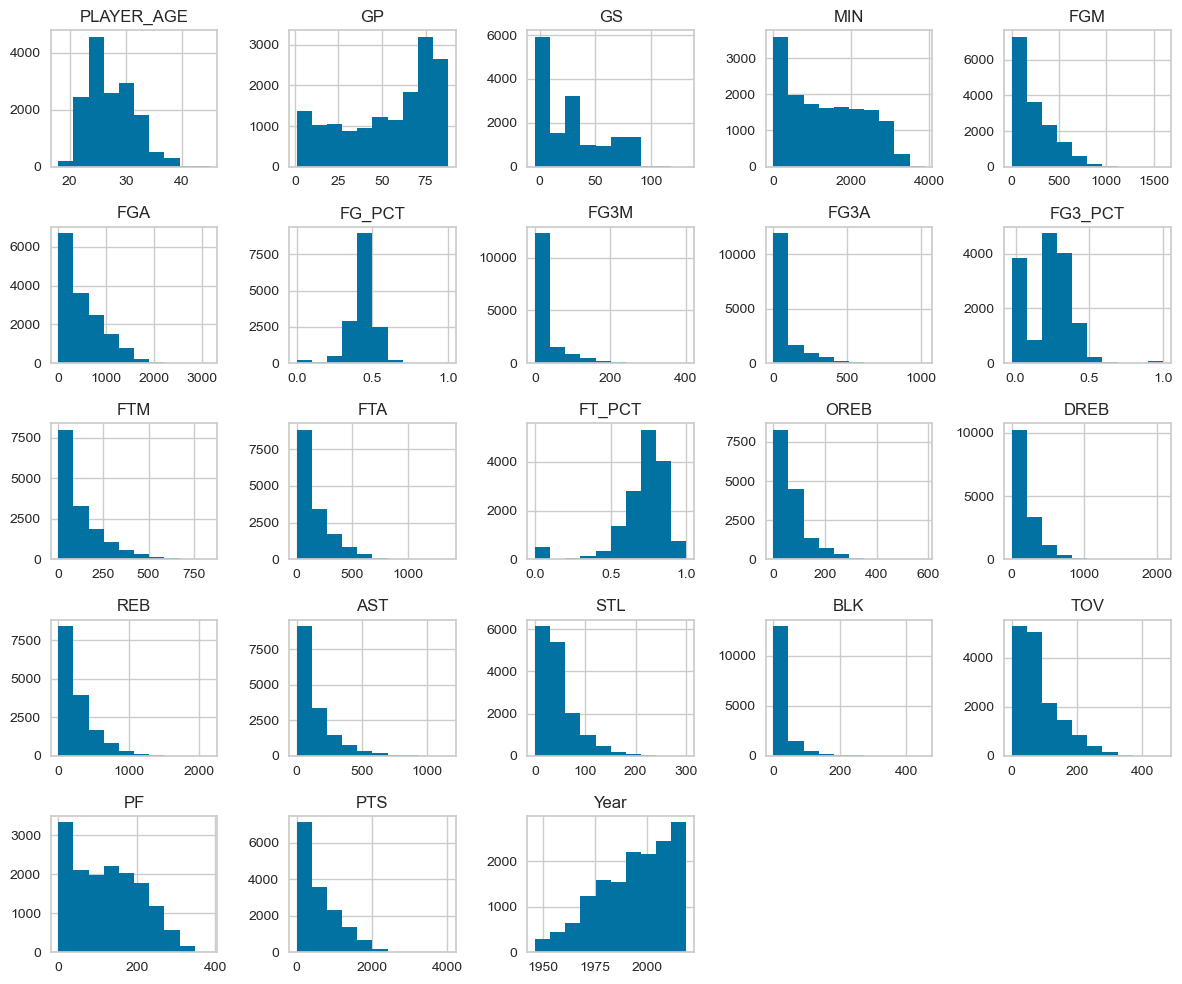

In [589]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Extract features (X) and target variable (if applicable)
X = data.drop(columns=['All_Star'])  # Replace 'target_column' with the name of your target column, if applicable

# Step 1: Check the ranges of the features
feature_ranges = X.max() - X.min()
print("Ranges of features:")
print(feature_ranges)

# Step 2: Optionally, visualize the distributions of the features
X.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()



Ranges of features after Min-Max scaling:
PLAYER_AGE    1.0
GP            1.0
GS            1.0
MIN           1.0
FGM           1.0
FGA           1.0
FG_PCT        1.0
FG3M          1.0
FG3A          1.0
FG3_PCT       1.0
FTM           1.0
FTA           1.0
FT_PCT        1.0
OREB          1.0
DREB          1.0
REB           1.0
AST           1.0
STL           1.0
BLK           1.0
TOV           1.0
PF            1.0
PTS           1.0
Year          1.0
dtype: float64


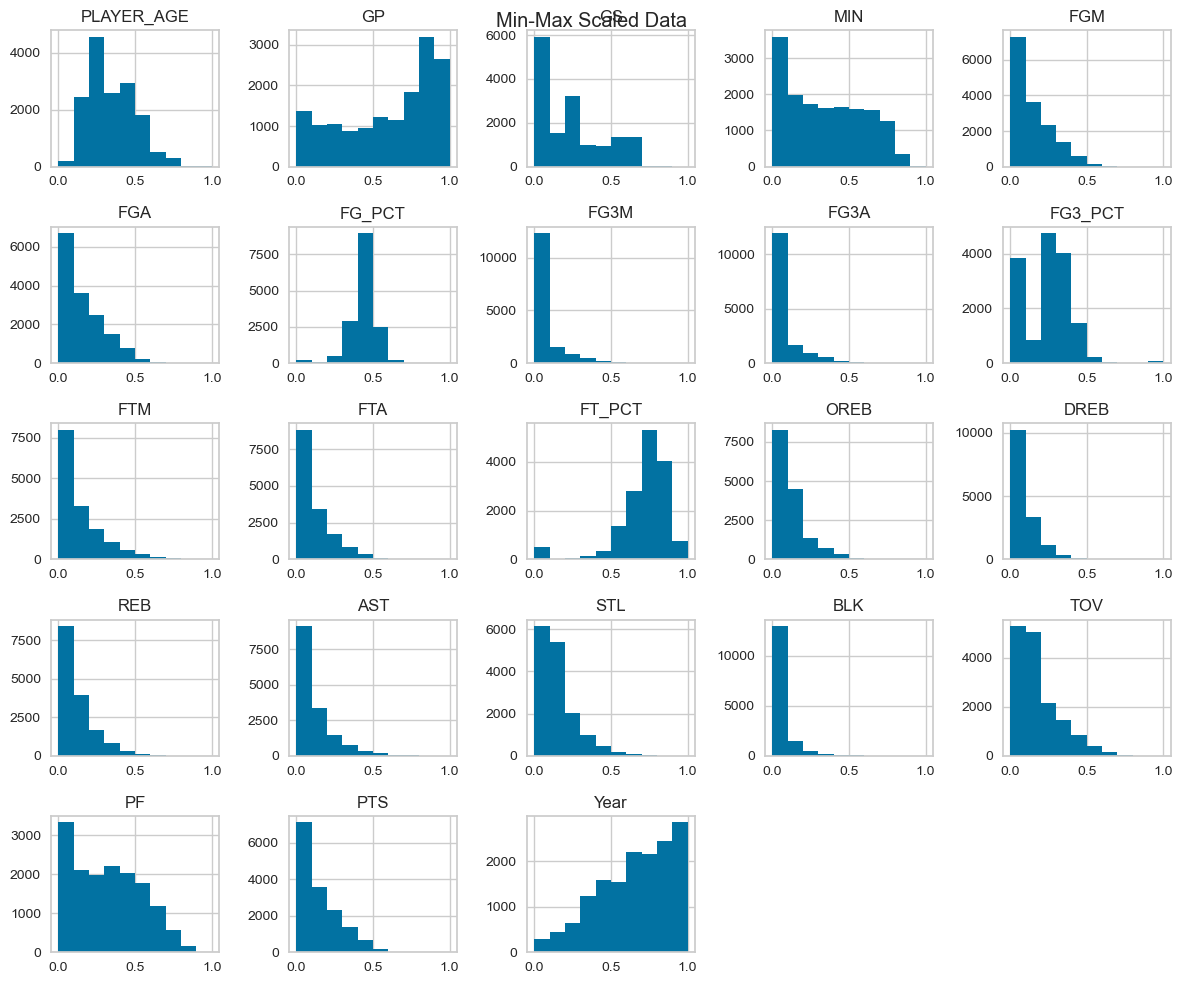


Ranges of features after Z-score normalization:
PLAYER_AGE     6.663951
GP             3.337272
GS             4.836161
MIN            3.978142
FGM            7.762556
FGA            7.309719
FG_PCT        10.804498
FG3M          10.284831
FG3A           9.891337
FG3_PCT        6.402486
FTM            6.631309
FTA            8.404953
FT_PCT         5.556675
OREB           8.767476
DREB          10.411230
REB            8.642474
AST            7.856405
STL            7.940524
BLK           12.334140
TOV            6.888181
PF             4.543080
PTS            7.431669
Year           4.143835
dtype: float64


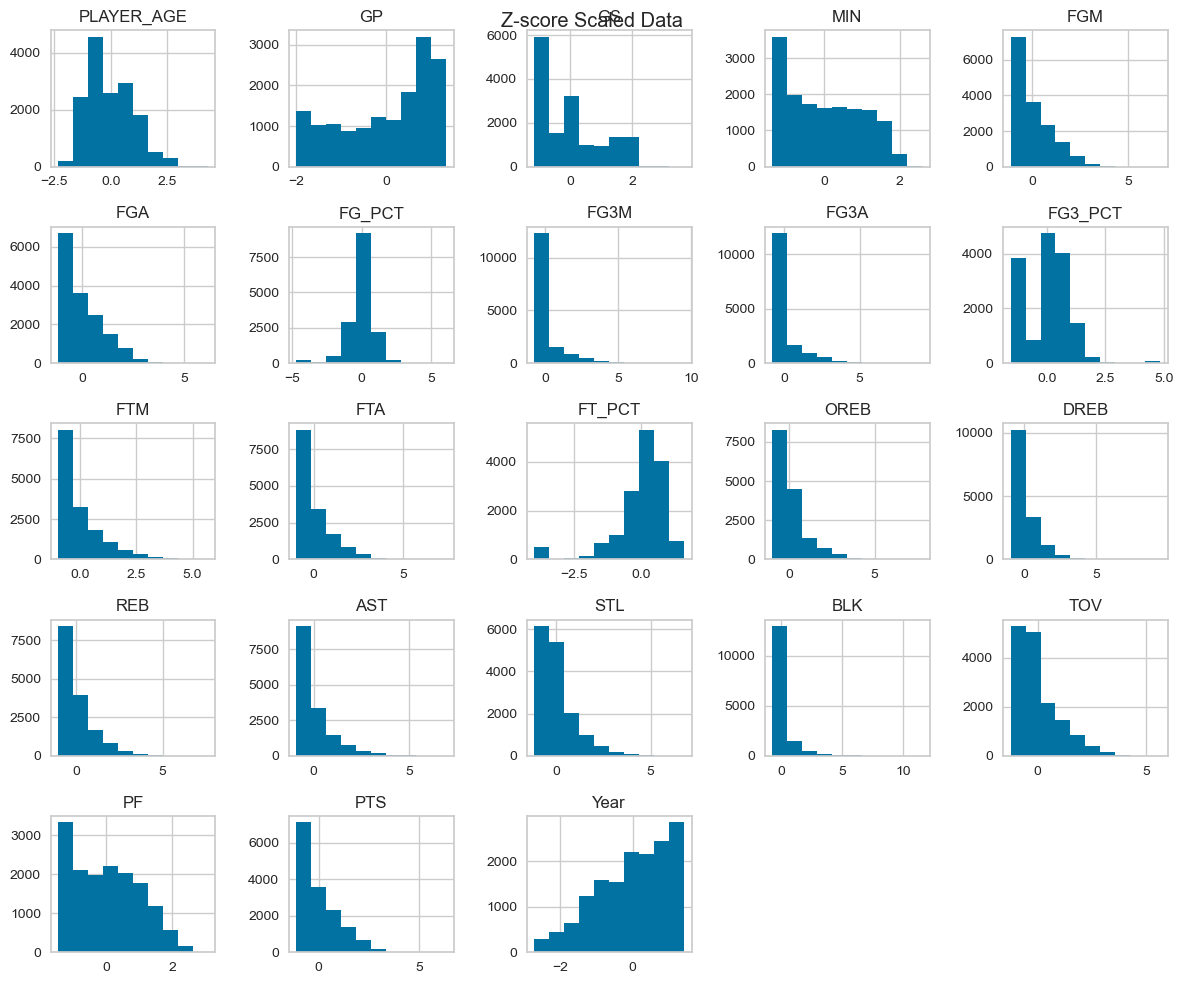

In [590]:
# Step 3: Apply normalization using Min-Max scaling
min_max_scaler = MinMaxScaler()
X_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

# Step 4: Compare the distributions and ranges of the normalized features
print("\nRanges of features after Min-Max scaling:")
print(X_min_max_scaled.max() - X_min_max_scaled.min())

# Optionally, visualize the distributions of the normalized features
X_min_max_scaled.hist(figsize=(12, 10))
plt.tight_layout()
plt.suptitle('Min-Max Scaled Data')
plt.show()

# Step 3: Apply normalization using Z-score normalization (Standardization)
standard_scaler = StandardScaler()
X_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(X), columns=X.columns)

# Step 4: Compare the distributions and ranges of the normalized features
print("\nRanges of features after Z-score normalization:")
print(X_standard_scaled.max() - X_standard_scaled.min())

# Optionally, visualize the distributions of the normalized features
X_standard_scaled.hist(figsize=(12, 10))
plt.tight_layout()
plt.suptitle('Z-score Scaled Data')
plt.show()


We chose Min-Max scaling over standardization because, in the context of predicting All-Star players, we aimed to ensure that each feature receives equal treatment in the predictive model by scaling them to the range [0, 1]. This normalization method maintains the relative importance of features while ensuring they contribute equally to the prediction process, thereby facilitating fair comparison and interpretation within the model.

In [591]:
X = data.drop(columns=['All_Star'])
min_max_scaler = MinMaxScaler()
X_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

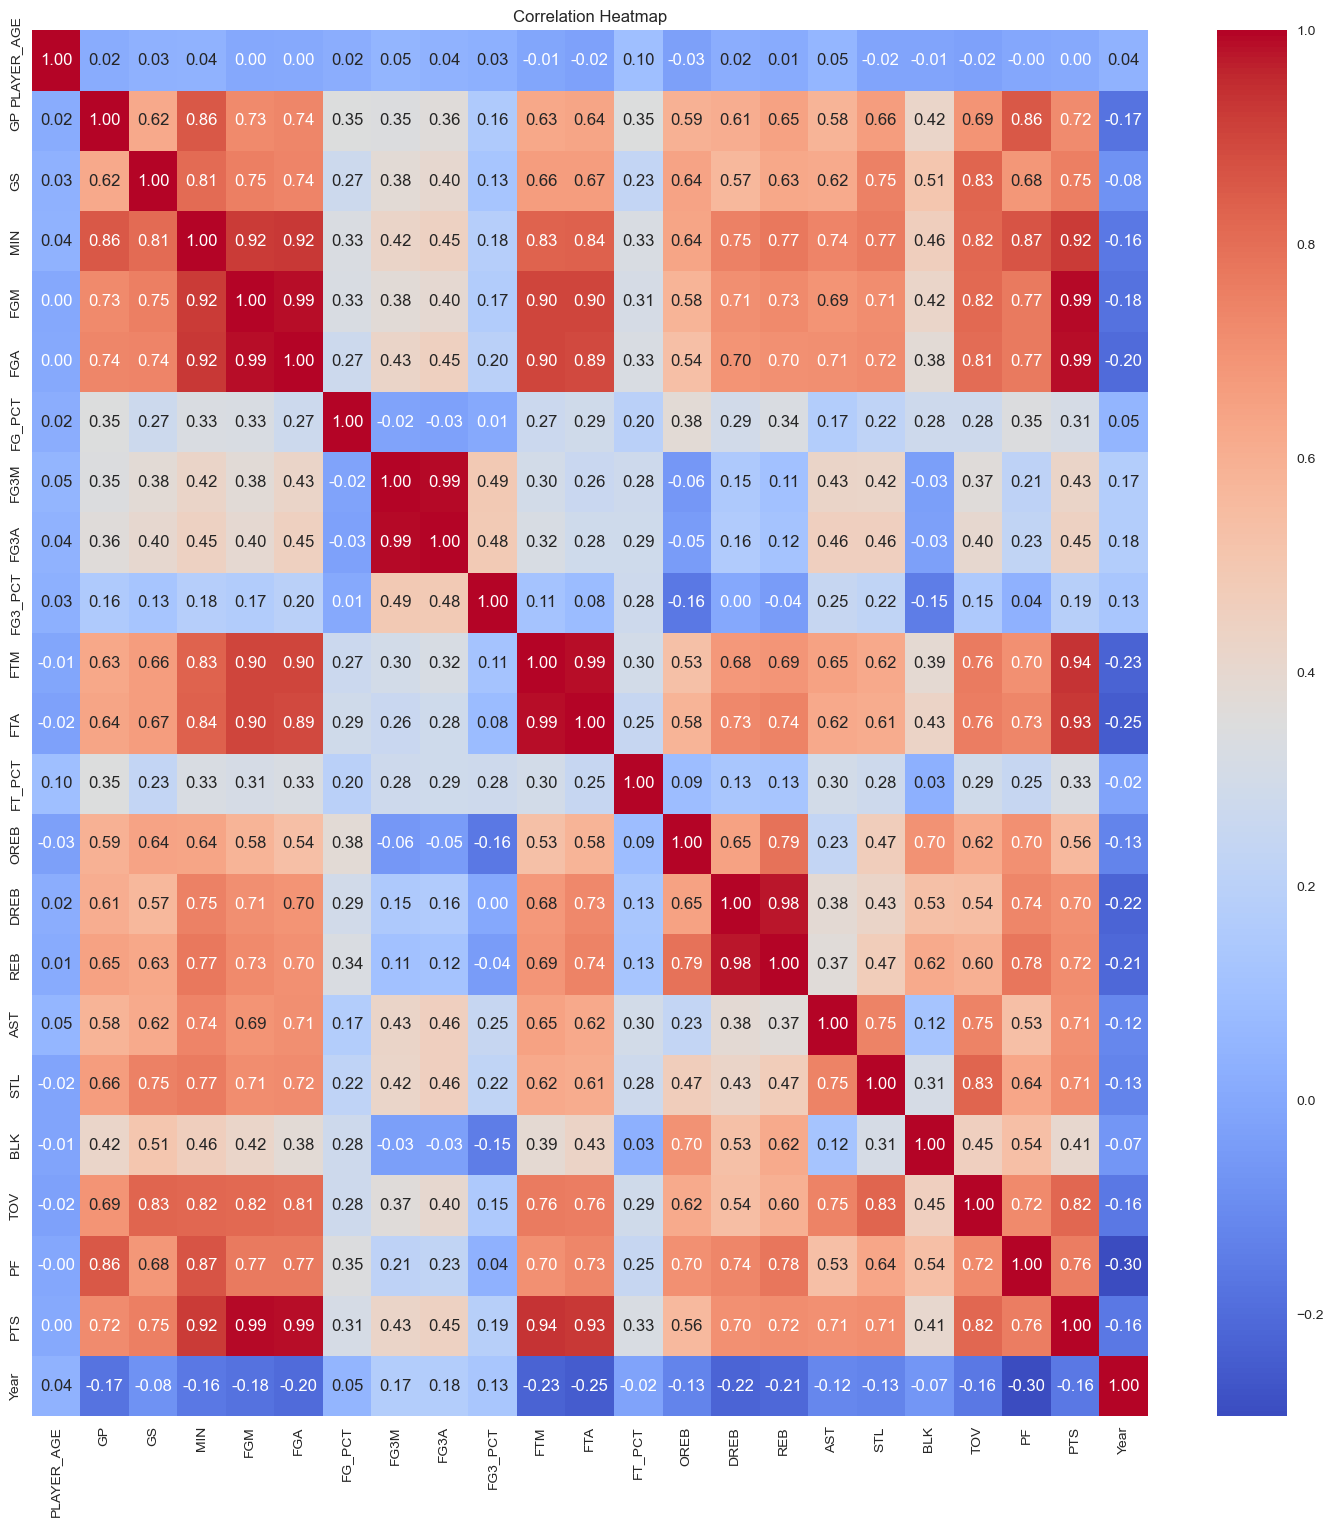

In [592]:
# Correlation heatmap to visualize feature correlations
plt.figure(figsize=(18, 18))
sns.heatmap(X_min_max_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

##### To avoid multicollinearity, columns with strong correlations between them should be removed. We will assess this using a heatmap.

In [593]:
data['PTS_MIN']=data['PTS']/data['MIN']
data['OREB_PCT'] =data['OREB']/data['REB'] 
data['DREB_PCT'] =data['DREB']/data['REB'] 

# Create a new feature indicating Player Efficiency Rating (PER)
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] - data['TOV']) / data['GP']

data = data.dropna()

In [594]:
data[['MIN', 'PTS', 'PTS_MIN','All_Star']][data['PTS_MIN'] == np.inf]

MIN  PTS  PTS_MIN  All_Star
11472  0.0  202      inf         0
12572  0.0  628      inf         0
2564   0.0  326      inf         0
10213  0.0  533      inf         0
1641   0.0   22      inf         0
9648   0.0  282      inf         0
9527   0.0   67      inf         0
3763   0.0  323      inf         0
9291   0.0  500      inf         0
3542   0.0  221      inf         0

In [595]:
data = data[data['PTS_MIN'] != np.inf]

In [596]:
# Dropping unnecessary columns from the DataFrame
data = data.drop(['FGM','FGA','FG3M','FG3A','FTM','FTA','PTS','MIN','DREB','OREB','REB'],axis=1)

In [597]:
X = data.drop(columns=['All_Star'])
min_max_scaler = MinMaxScaler()
X_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

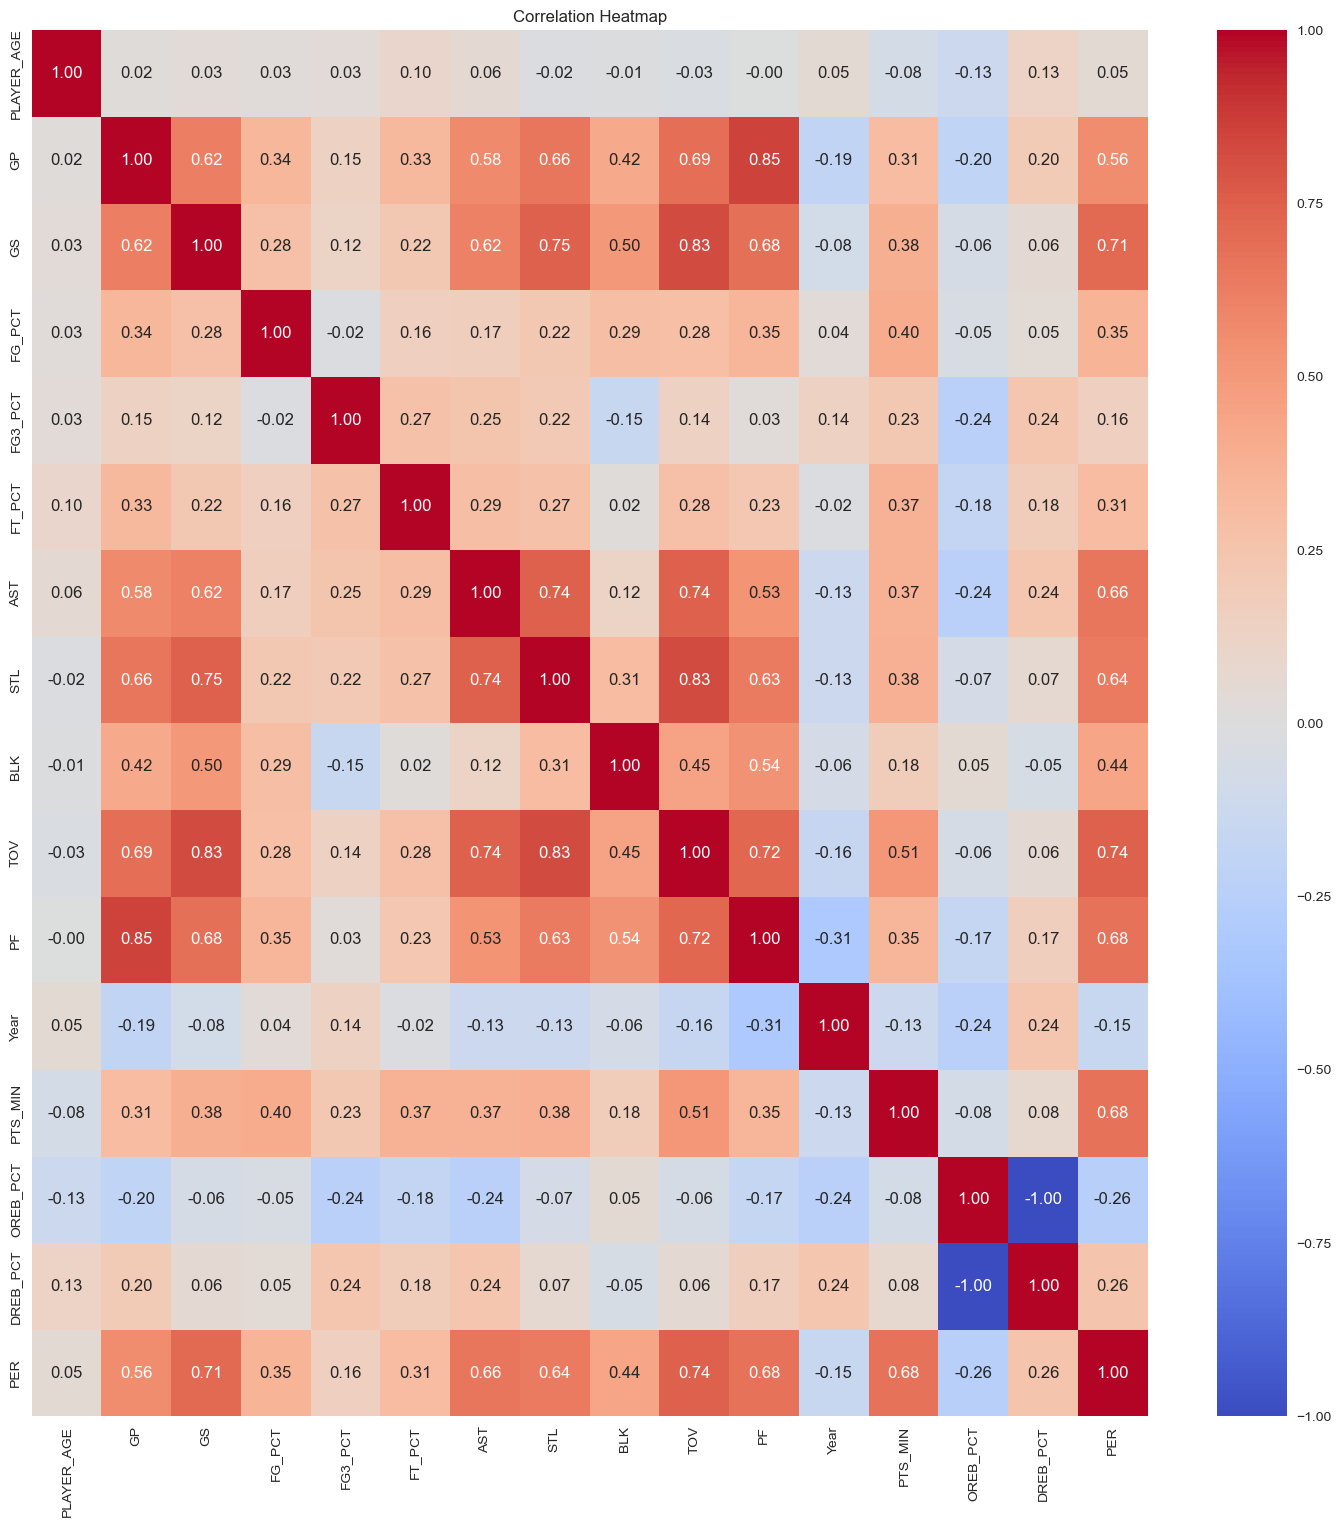

In [598]:
# Correlation heatmap to visualize feature correlations
plt.figure(figsize=(18, 18))
sns.heatmap(X_min_max_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### Anomaly Detection

#### Investigating

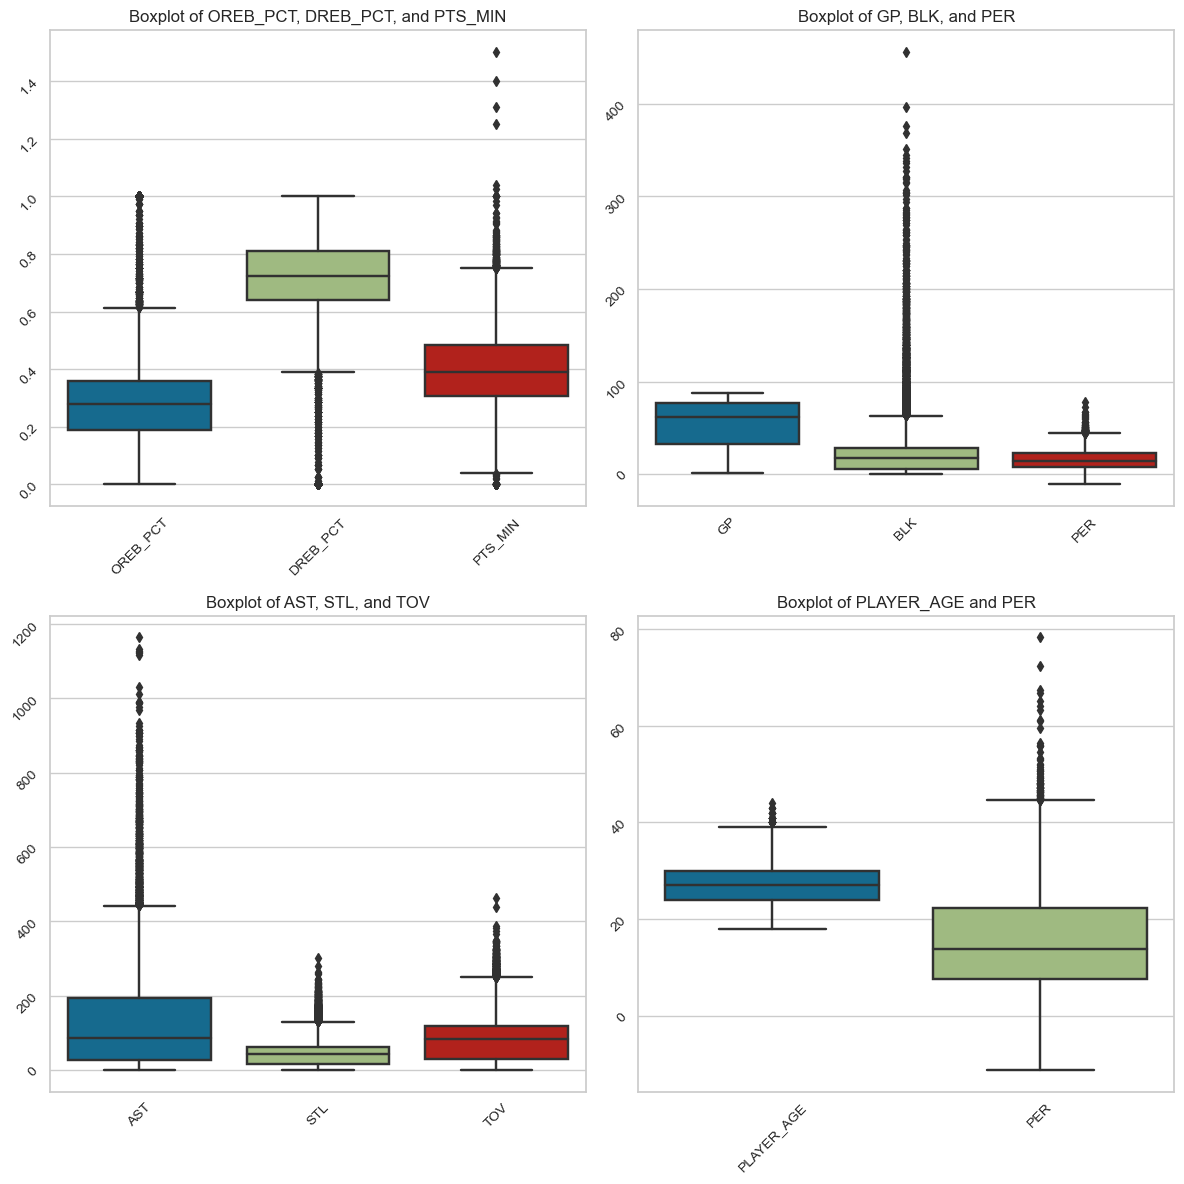

In [599]:
# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: 'OREB_PCT', 'DREB_PCT', 'PER'
sns.boxplot(data=data[['OREB_PCT', 'DREB_PCT', 'PTS_MIN']], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of OREB_PCT, DREB_PCT, and PTS_MIN')
axes[0, 0].tick_params(rotation=45)

# Plot 2: 'PLAYER_AGE', 'GP', 'PTS_MIN', 'BLK'
sns.boxplot(data=data[['GP', 'BLK','PER']], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of GP, BLK, and PER')
axes[0, 1].tick_params(rotation=45)

# Plot 3: 'AST', 'STL', 'TOV'
sns.boxplot(data=data[['AST', 'STL', 'TOV']], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of AST, STL, and TOV')
axes[1, 0].tick_params(rotation=45)

# Plot 4: 'PLAYER_AGE', 'PER'
sns.boxplot(data=data[['PLAYER_AGE', 'PER']], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of PLAYER_AGE and PER')
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
plt.show()


In [600]:
data['AST'].describe()

count    15156.000000
mean       135.428411
std        148.466883
min          0.000000
25%         27.000000
50%         87.000000
75%        193.000000
max       1164.000000
Name: AST, dtype: float64

In [601]:
data['BLK'].describe()

count    15156.000000
mean        27.310762
std         37.148337
min          0.000000
25%          5.000000
50%         17.000000
75%         28.250000
max        456.000000
Name: BLK, dtype: float64

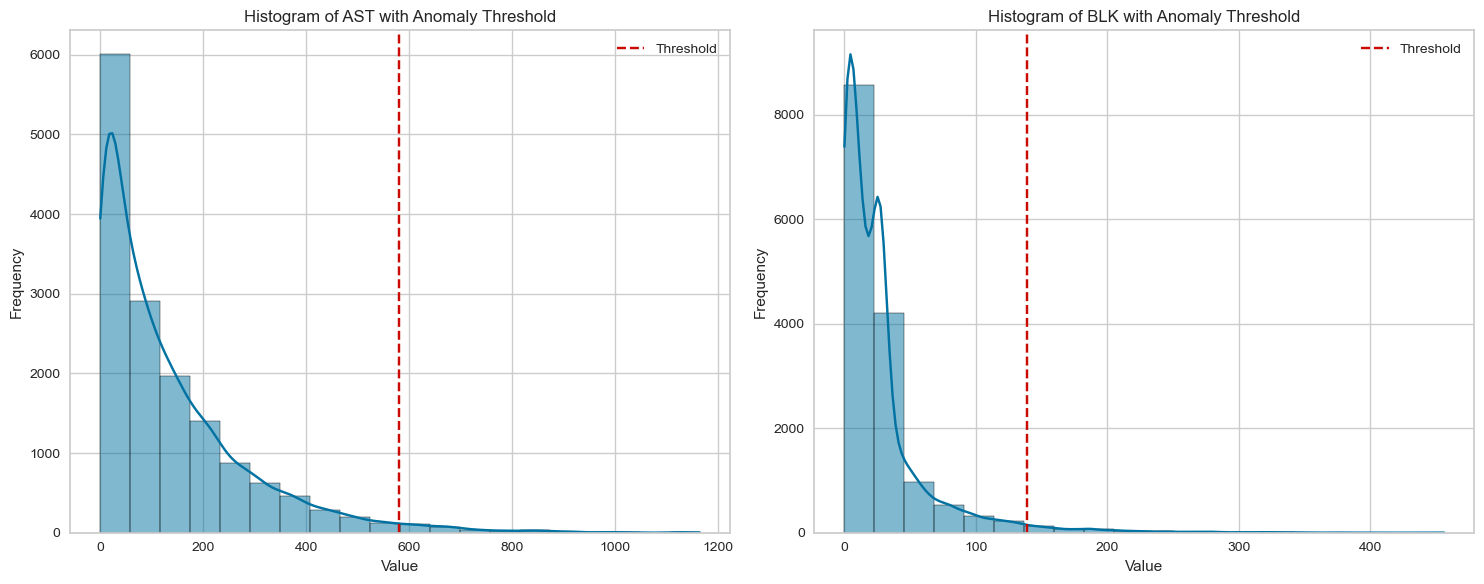

In [602]:
# Step 3: Statistical Analysis
# Calculate summary statistics to identify anomalies
mean_ast = data['AST'].mean()
std_dev_ast = data['AST'].std()
threshold_ast = 3  # Define a threshold for anomalies (e.g., 3 standard deviations from the mean)

mean_blk = data['BLK'].mean()
std_dev_blk = data['BLK'].std()
threshold_blk = 3  # Define a threshold for anomalies (e.g., 3 standard deviations from the mean)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram with threshold for AST column
sns.histplot(data['AST'], bins=20, kde=True, ax=axs[0])
axs[0].axvline(x=mean_ast + threshold_ast * std_dev_ast, color='r', linestyle='--', label='Threshold')
axs[0].legend()
axs[0].set_title('Histogram of AST with Anomaly Threshold')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot histogram with threshold for BLK column
sns.histplot(data['BLK'], bins=20, kde=True, ax=axs[1])
axs[1].axvline(x=mean_blk + threshold_blk * std_dev_blk, color='r', linestyle='--', label='Threshold')
axs[1].legend()
axs[1].set_title('Histogram of BLK with Anomaly Threshold')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Distance-based

In [603]:
# DBSCAN
dbscan_ast = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_ast.fit(data[['Year', 'AST']])
outlier_labels_dbscan_ast = dbscan_ast.labels_
outliers_dbscan_ast = data[outlier_labels_dbscan_ast == -1]

dbscan_blk = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_blk.fit(data[['Year', 'BLK']])
outlier_labels_dbscan_blk = dbscan_blk.labels_
outliers_dbscan_blk = data[outlier_labels_dbscan_blk == -1]

# LOF
lof_ast = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed
outlier_labels_lof_ast = lof_ast.fit_predict(data[['Year', 'AST']])
outliers_lof_ast = data[outlier_labels_lof_ast == -1]

lof_blk = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed
outlier_labels_lof_blk = lof_blk.fit_predict(data[['Year', 'BLK']])
outliers_lof_blk = data[outlier_labels_lof_blk == -1]

# KNN for AST
knn_ast = NearestNeighbors(n_neighbors=5)
knn_ast.fit(data[['Year', 'AST']])
distances_ast, indices_ast = knn_ast.kneighbors(data[['Year', 'AST']])
outliers_knn_indices_ast = indices_ast[distances_ast[:, -1] < threshold_ast]  # Adjust threshold as needed
outliers_knn_indices_ast_flat = outliers_knn_indices_ast.flatten()
outliers_knn_ast = data.iloc[outliers_knn_indices_ast_flat]

# KNN for BLK
knn_blk = NearestNeighbors(n_neighbors=5)
knn_blk.fit(data[['Year', 'BLK']])
distances_blk, indices_blk = knn_blk.kneighbors(data[['Year', 'BLK']])
outliers_knn_indices_blk = indices_blk[distances_blk[:, -1] < threshold_blk]  # Adjust threshold as needed
outliers_knn_indices_blk_flat = outliers_knn_indices_blk.flatten()
outliers_knn_blk = data.iloc[outliers_knn_indices_blk_flat]



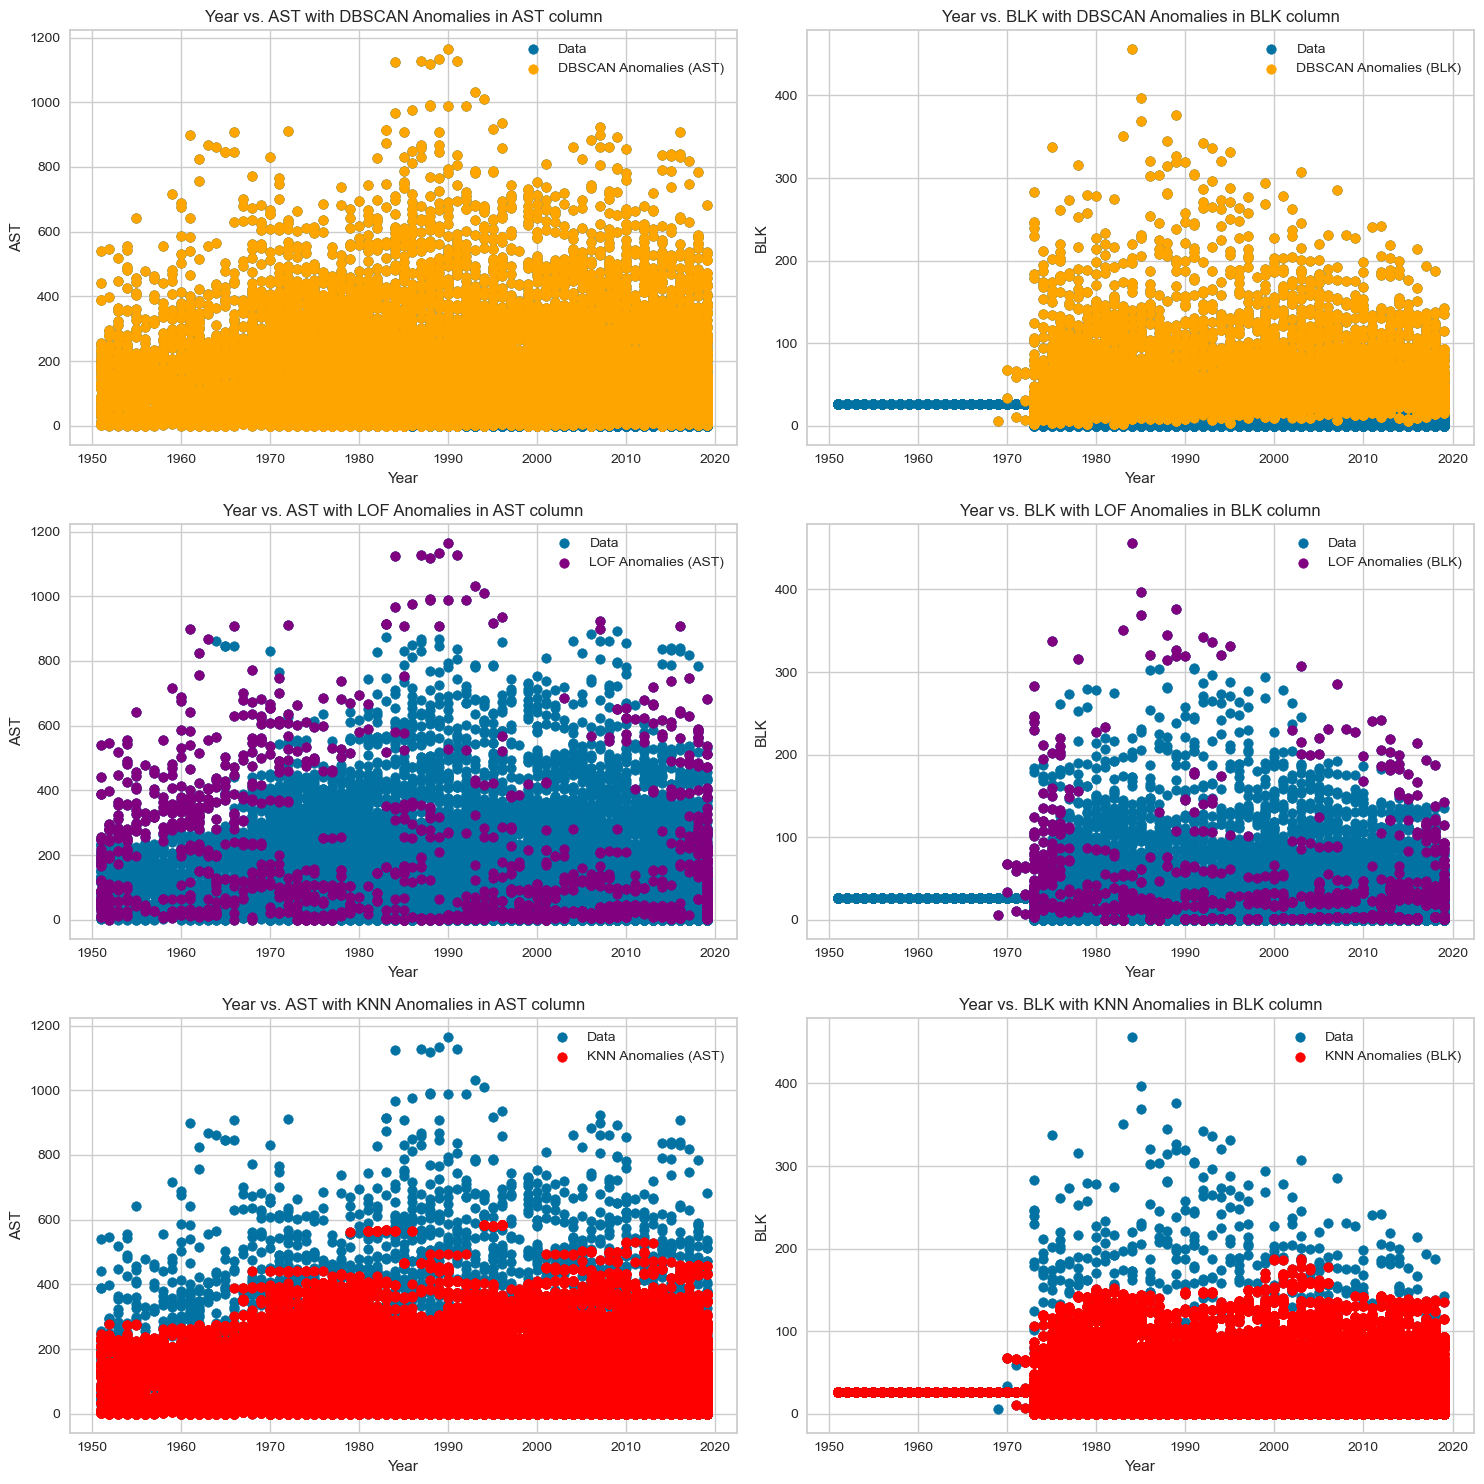

In [604]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# DBSCAN
axs[0, 0].scatter(data['Year'], data['AST'], label='Data')
axs[0, 0].scatter(outliers_dbscan_ast['Year'], outliers_dbscan_ast['AST'], color='orange', label='DBSCAN Anomalies (AST)')
axs[0, 0].set_title('Year vs. AST with DBSCAN Anomalies in AST column')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('AST')
axs[0, 0].legend()

axs[0, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[0, 1].scatter(outliers_dbscan_blk['Year'], outliers_dbscan_blk['BLK'], color='orange', label='DBSCAN Anomalies (BLK)')
axs[0, 1].set_title('Year vs. BLK with DBSCAN Anomalies in BLK column')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('BLK')
axs[0, 1].legend()

# LOF
axs[1, 0].scatter(data['Year'], data['AST'], label='Data')
axs[1, 0].scatter(outliers_lof_ast['Year'], outliers_lof_ast['AST'], color='purple', label='LOF Anomalies (AST)')
axs[1, 0].set_title('Year vs. AST with LOF Anomalies in AST column')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('AST')
axs[1, 0].legend()

axs[1, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[1, 1].scatter(outliers_lof_blk['Year'], outliers_lof_blk['BLK'], color='purple', label='LOF Anomalies (BLK)')
axs[1, 1].set_title('Year vs. BLK with LOF Anomalies in BLK column')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('BLK')
axs[1, 1].legend()

# KNN
axs[2, 0].scatter(data['Year'], data['AST'], label='Data')
axs[2, 0].scatter(outliers_knn_ast['Year'], outliers_knn_ast['AST'], color='red', label='KNN Anomalies (AST)')
axs[2, 0].set_title('Year vs. AST with KNN Anomalies in AST column')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('AST')
axs[2, 0].legend()

axs[2, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[2, 1].scatter(outliers_knn_blk['Year'], outliers_knn_blk['BLK'], color='red', label='KNN Anomalies (BLK)')
axs[2, 1].set_title('Year vs. BLK with KNN Anomalies in BLK column')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('BLK')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


#### Model-based

In [605]:
# One-Class SVM for AST
svm_ast = OneClassSVM(nu=0.1)  # Adjust nu parameter as needed
svm_ast.fit(data[['Year', 'AST']])
outliers_svm_indices_ast = svm_ast.predict(data[['Year', 'AST']]) == -1
outliers_svm_ast = data[outliers_svm_indices_ast]

# One-Class SVM for BLK
svm_blk = OneClassSVM(nu=0.1)  # Adjust nu parameter as needed
svm_blk.fit(data[['Year', 'BLK']])
outliers_svm_indices_blk = svm_blk.predict(data[['Year', 'BLK']]) == -1
outliers_svm_blk = data[outliers_svm_indices_blk]

# Isolation Forest for AST
isolation_forest_ast = IsolationForest(contamination=0.1)  # Adjust contamination as needed
isolation_forest_ast.fit(data[['Year', 'AST']])
outliers_isolation_forest_indices_ast = isolation_forest_ast.predict(data[['Year', 'AST']]) == -1
outliers_isolation_forest_ast = data[outliers_isolation_forest_indices_ast]

# Isolation Forest for BLK
isolation_forest_blk = IsolationForest(contamination=0.1)  # Adjust contamination as needed
isolation_forest_blk.fit(data[['Year', 'BLK']])
outliers_isolation_forest_indices_blk = isolation_forest_blk.predict(data[['Year', 'BLK']]) == -1
outliers_isolation_forest_blk = data[outliers_isolation_forest_indices_blk]

# Clustering-Based Methods for AST
kmeans_ast = KMeans(n_clusters=2)  # Adjust number of clusters as needed
kmeans_ast.fit(data[['Year', 'AST']])
outliers_kmeans_indices_ast = kmeans_ast.predict(data[['Year', 'AST']]) == 0  # Assuming cluster 0 is outliers
outliers_kmeans_ast = data[outliers_kmeans_indices_ast]

# Clustering-Based Methods for BLK
kmeans_blk = KMeans(n_clusters=2)  #
kmeans_blk.fit(data[['Year', 'BLK']])
outliers_kmeans_indices_blk = kmeans_blk.predict(data[['Year', 'BLK']]) == 0  # Assuming cluster 0 is outliers
outliers_kmeans_blk = data[outliers_kmeans_indices_blk]

C:\Users\liron\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

C:\Users\liron\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



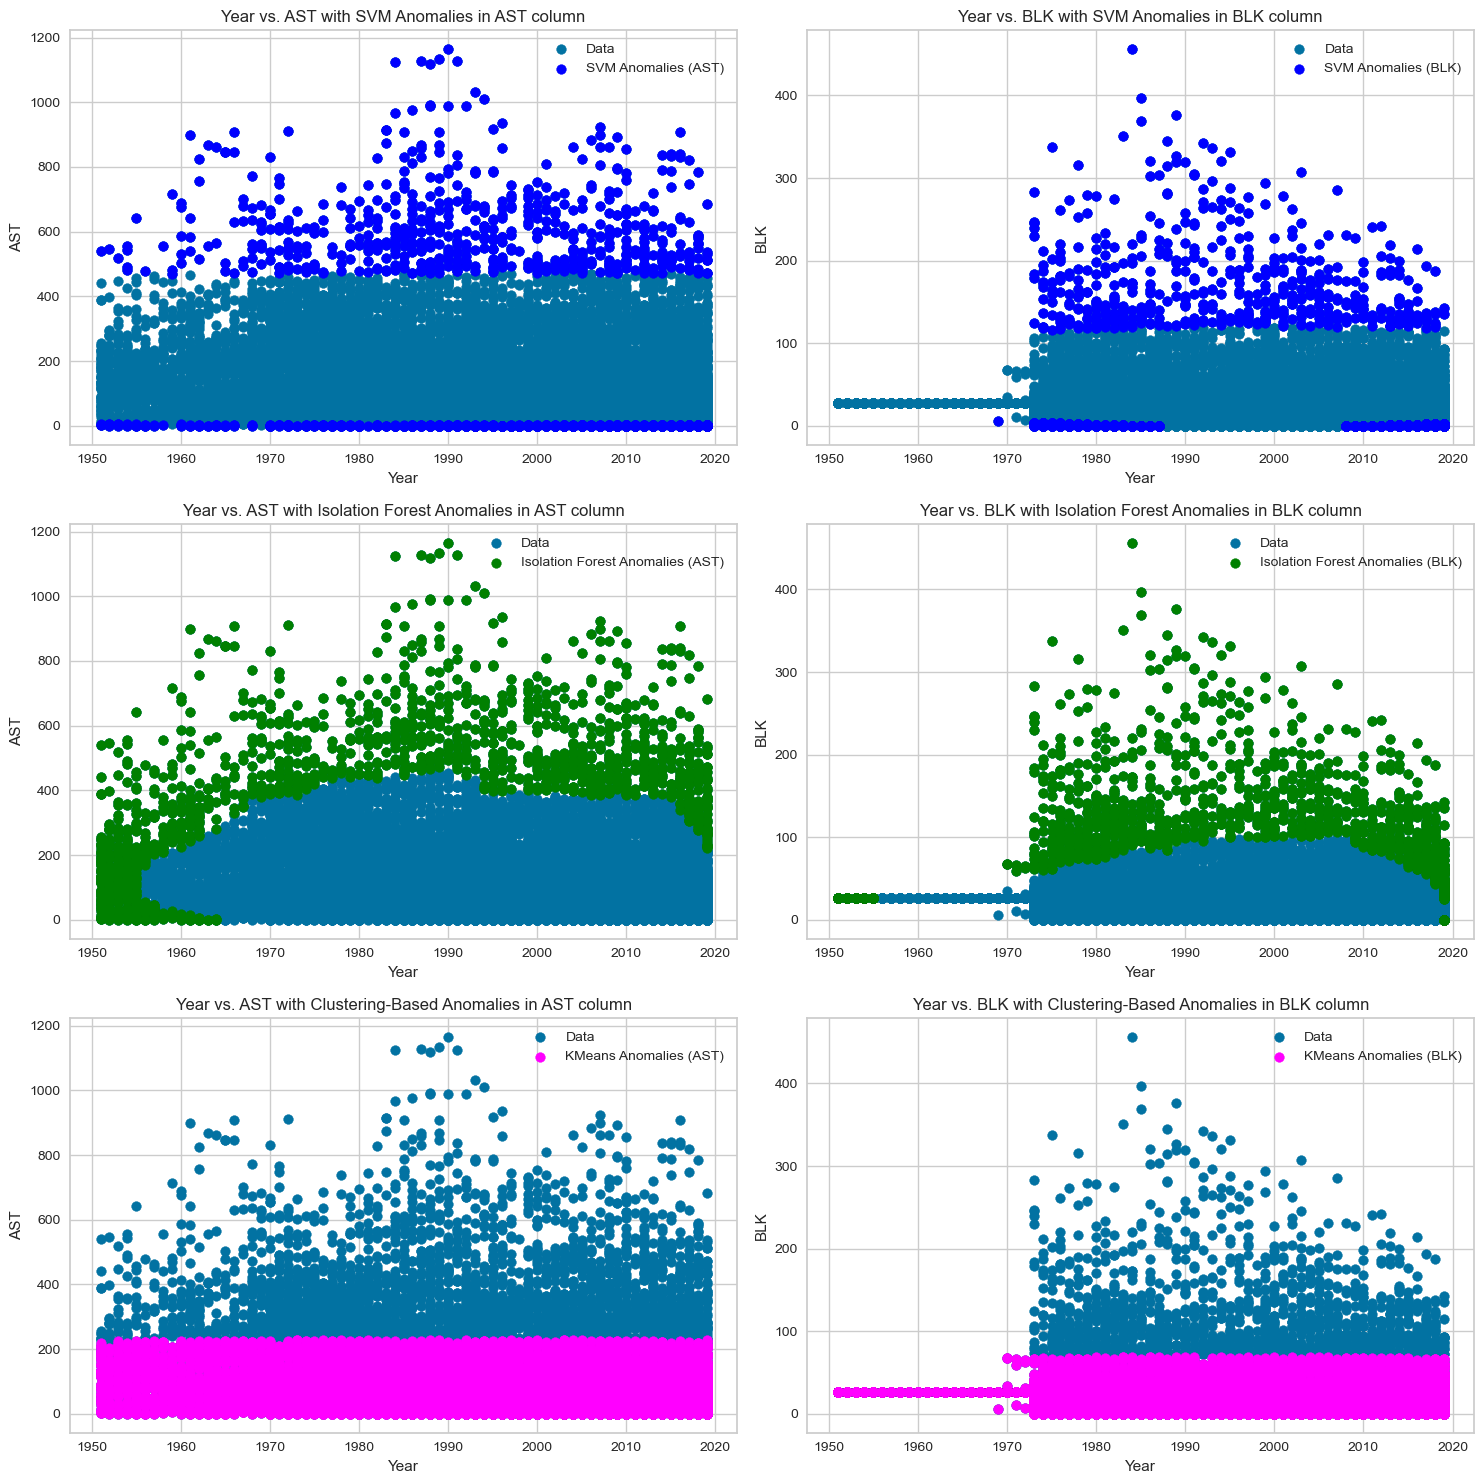

In [606]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# One-Class SVM for AST
axs[0, 0].scatter(data['Year'], data['AST'], label='Data')
axs[0, 0].scatter(outliers_svm_ast['Year'], outliers_svm_ast['AST'], color='blue', label='SVM Anomalies (AST)')
axs[0, 0].set_title('Year vs. AST with SVM Anomalies in AST column')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('AST')
axs[0, 0].legend()

# One-Class SVM for BLK
axs[0, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[0, 1].scatter(outliers_svm_blk['Year'], outliers_svm_blk['BLK'], color='blue', label='SVM Anomalies (BLK)')
axs[0, 1].set_title('Year vs. BLK with SVM Anomalies in BLK column')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('BLK')
axs[0, 1].legend()

# Isolation Forest for AST
axs[1, 0].scatter(data['Year'], data['AST'], label='Data')
axs[1, 0].scatter(outliers_isolation_forest_ast['Year'], outliers_isolation_forest_ast['AST'], color='green', label='Isolation Forest Anomalies (AST)')
axs[1, 0].set_title('Year vs. AST with Isolation Forest Anomalies in AST column')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('AST')
axs[1, 0].legend()

# Isolation Forest for BLK
axs[1, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[1, 1].scatter(outliers_isolation_forest_blk['Year'], outliers_isolation_forest_blk['BLK'], color='green', label='Isolation Forest Anomalies (BLK)')
axs[1, 1].set_title('Year vs. BLK with Isolation Forest Anomalies in BLK column')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('BLK')
axs[1, 1].legend()

# Clustering-Based Methods for AST
axs[2, 0].scatter(data['Year'], data['AST'], label='Data')
axs[2, 0].scatter(outliers_kmeans_ast['Year'], outliers_kmeans_ast['AST'], color='magenta', label='KMeans Anomalies (AST)')
axs[2, 0].set_title('Year vs. AST with Clustering-Based Anomalies in AST column')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('AST')
axs[2, 0].legend()

# Clustering-Based Methods for BLK
axs[2, 1].scatter(data['Year'], data['BLK'], label='Data')
axs[2, 1].scatter(outliers_kmeans_blk['Year'], outliers_kmeans_blk['BLK'], color='magenta', label='KMeans Anomalies (BLK)')
axs[2, 1].set_title('Year vs. BLK with Clustering-Based Anomalies in BLK column')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('BLK')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


After detecting anomalies using different models and creating relevant outputs, we identified several abnormal points. After actual data verification, our data set is confirmed to consist of authentic data and not false or incorrect data. Therefore, we recommended recognizing the exceptions and incorporating them into the account for the further development of the project.After detecting anomalies using different models and creating relevant outputs, we identified several abnormal points. After actual data verification, our data set is confirmed to consist of authentic data and not false or incorrect data. Therefore, we recommended recognizing the exceptions and incorporating them into the account for the further development of the project.

### Data preparation, feature scaling and Models
#### As mentioned previously, it's essential to ensure in the 'train-test split' step that the model learns from the past and predicts the future.

#### Model Training and Evaluation (without clustering)


In [607]:
min_max_scaler = MinMaxScaler()
X = data.drop('All_Star', axis=1)
X_scaled = min_max_scaler.fit_transform(X)
y = data['All_Star']

# Train-test split for time series data
train_size = int(0.8 * len(data))  # 80% of the data for training

# Splitting features (X) and target variable (y)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

[LightGBM] [Info] Number of positive: 1395, number of negative: 10729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3426
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115061 -> initscore=-2.040056
[LightGBM] [Info] Start training from score -2.040056
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2823
           1       0.69      0.25      0.37       209

    accuracy                           0.94      3032
   macro avg       0.82      0.62      0.67      3032
weighted avg       0.93      0.94      0.93      3032



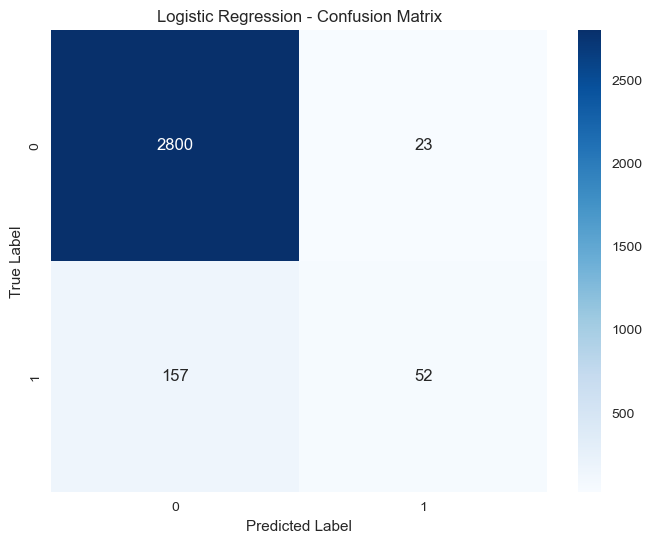

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.63      0.50      0.55       209

    accuracy                           0.94      3032
   macro avg       0.79      0.74      0.76      3032
weighted avg       0.94      0.94      0.94      3032



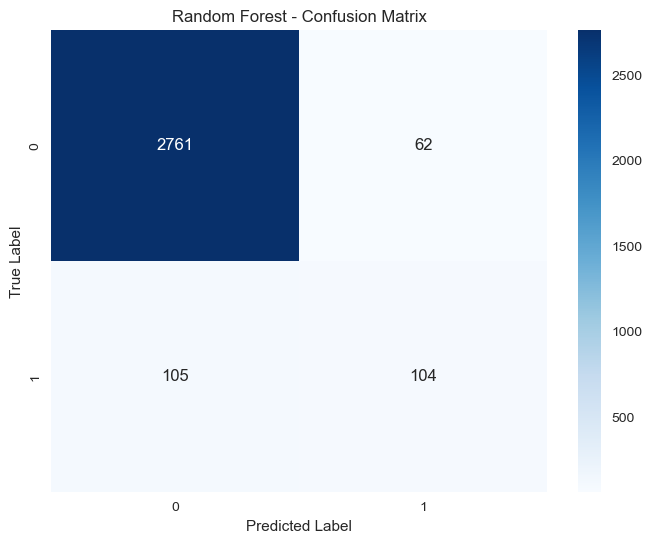

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.59      0.61      0.60       209

    accuracy                           0.94      3032
   macro avg       0.78      0.79      0.78      3032
weighted avg       0.94      0.94      0.94      3032



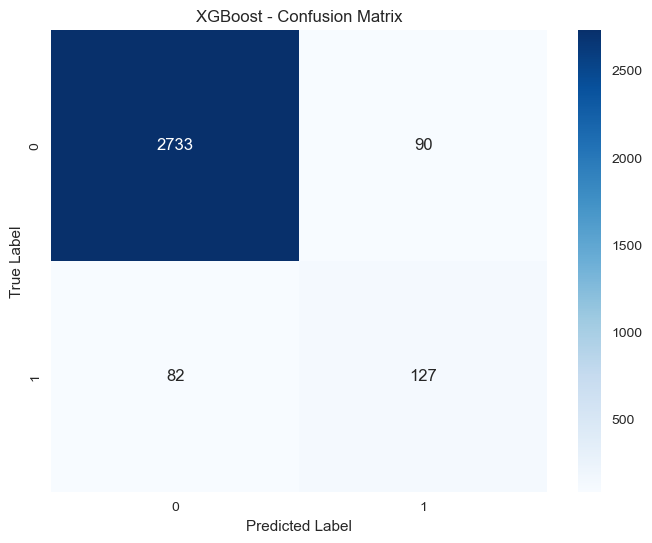

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2823
           1       0.65      0.53      0.58       209

    accuracy                           0.95      3032
   macro avg       0.81      0.75      0.78      3032
weighted avg       0.94      0.95      0.95      3032



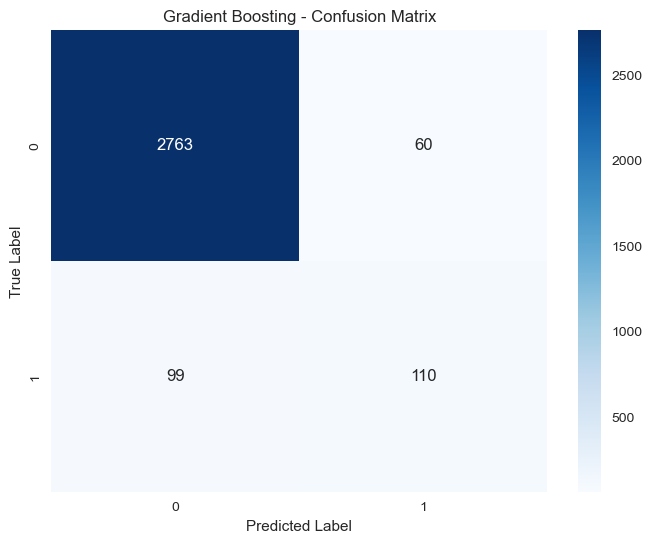

AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.49      0.55       209

    accuracy                           0.94      3032
   macro avg       0.79      0.73      0.76      3032
weighted avg       0.94      0.94      0.94      3032



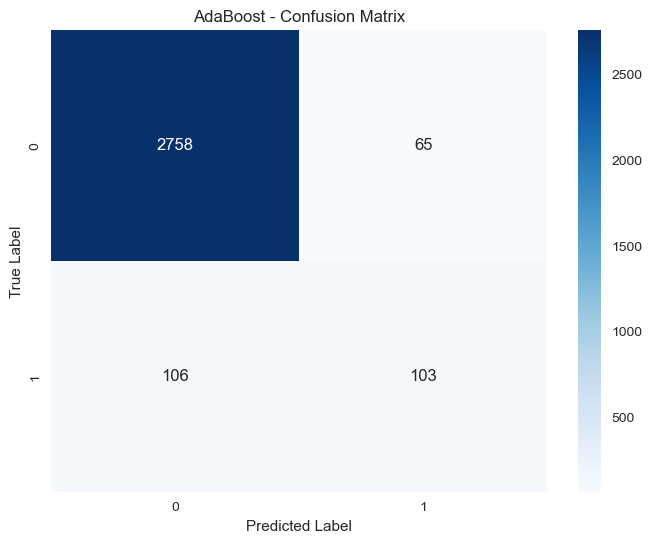

LGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.64      0.60      0.62       209

    accuracy                           0.95      3032
   macro avg       0.80      0.79      0.80      3032
weighted avg       0.95      0.95      0.95      3032



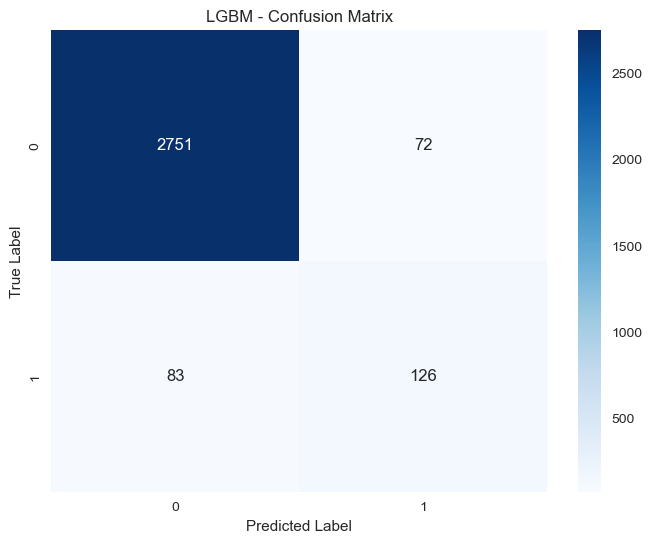

In [608]:
# Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

#Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# XGBoost Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Gradient Boosting Model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# AdaBoost Model
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

# LGBM Model
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Model Evaluation - Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# Confusion Matrix - Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logistic), annot=True, cmap='Blues', fmt='d')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Evaluation - Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix - Random Forest
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap='Blues', fmt='d')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Evaluation - XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix - XGBoost
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap='Blues', fmt='d')
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Evaluation - Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix - Gradient Boosting
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, cmap='Blues', fmt='d')
plt.title('Gradient Boosting - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Evaluation - AdaBoost
y_pred_ada = ada_model.predict(X_test)
print("AdaBoost - Classification Report:")
print(classification_report(y_test, y_pred_ada))

# Confusion Matrix - AdaBoost
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, cmap='Blues', fmt='d')
plt.title('AdaBoost - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Evaluation - LGBM
y_pred_lgbm = lgbm_model.predict(X_test)
print("LGBM - Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix - LGBM
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, cmap='Blues', fmt='d')
plt.title('LGBM - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [609]:
data.columns

Index(['PLAYER_AGE', 'GP', 'GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'Year', 'All_Star', 'PTS_MIN', 'OREB_PCT',
       'DREB_PCT', 'PER'],
      dtype='object')

#### Finding the best parameters for the models

In [ ]:
# Define parameter grids for each model
param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
param_grid_gb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}
param_grid_ada = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}
param_grid_lgbm = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}

# Define models
models = {
    'Logistic Regression': (LogisticRegression(), param_grid_logistic),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'XGBoost': (XGBClassifier(), param_grid_xgb),
    'Gradient Boosting': (GradientBoostingClassifier(), param_grid_gb),
    'AdaBoost': (AdaBoostClassifier(), param_grid_ada),
    'LGBM': (LGBMClassifier(), param_grid_lgbm)
}

# Train each model and select the best parameters
best_models = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

In [ ]:
best_models

In [ ]:
data.columns


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2823
           1       0.69      0.25      0.37       209

    accuracy                           0.94      3032
   macro avg       0.82      0.62      0.67      3032
weighted avg       0.93      0.94      0.93      3032



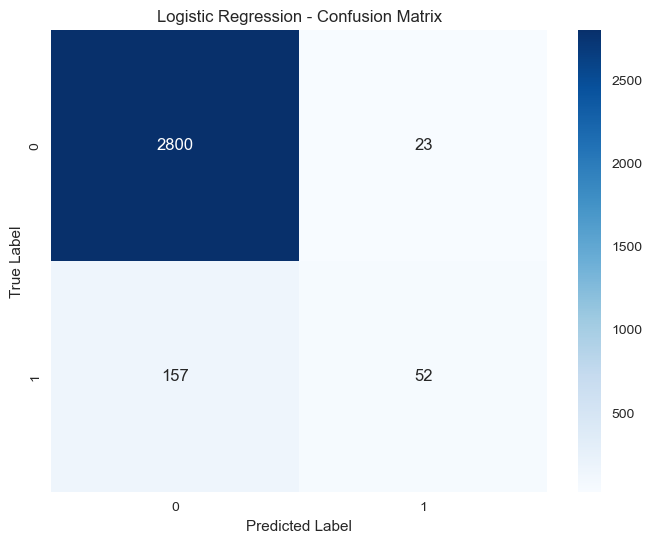


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.49      0.54       209

    accuracy                           0.94      3032
   macro avg       0.79      0.73      0.76      3032
weighted avg       0.94      0.94      0.94      3032



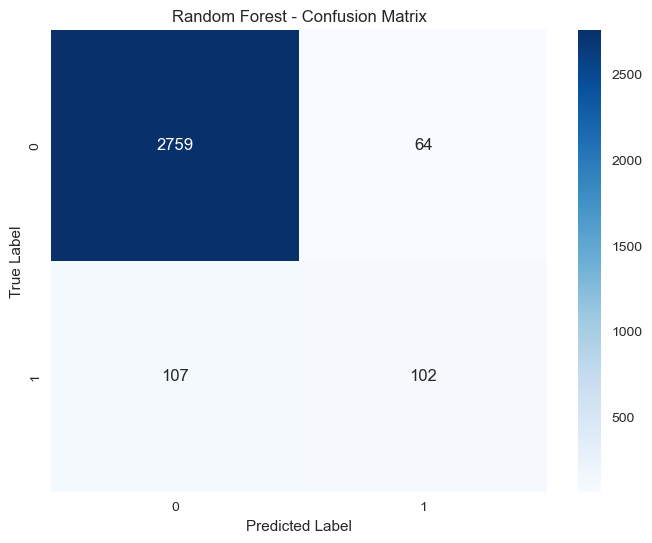


XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.59      0.61      0.60       209

    accuracy                           0.94      3032
   macro avg       0.78      0.79      0.78      3032
weighted avg       0.94      0.94      0.94      3032



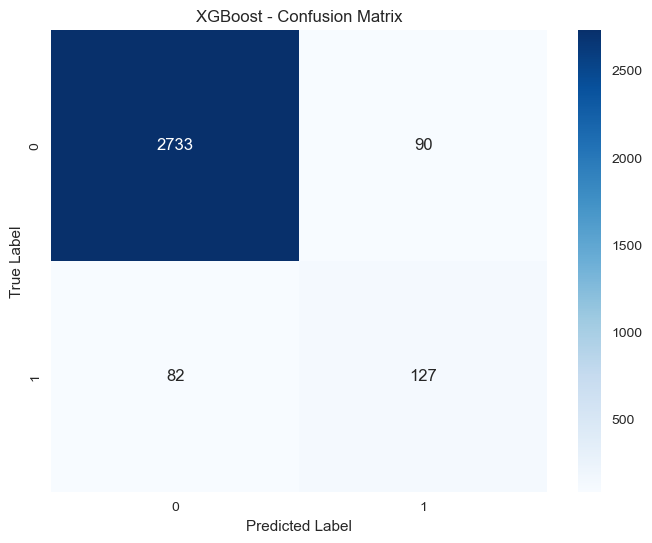


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2823
           1       0.65      0.53      0.58       209

    accuracy                           0.95      3032
   macro avg       0.81      0.75      0.78      3032
weighted avg       0.94      0.95      0.95      3032



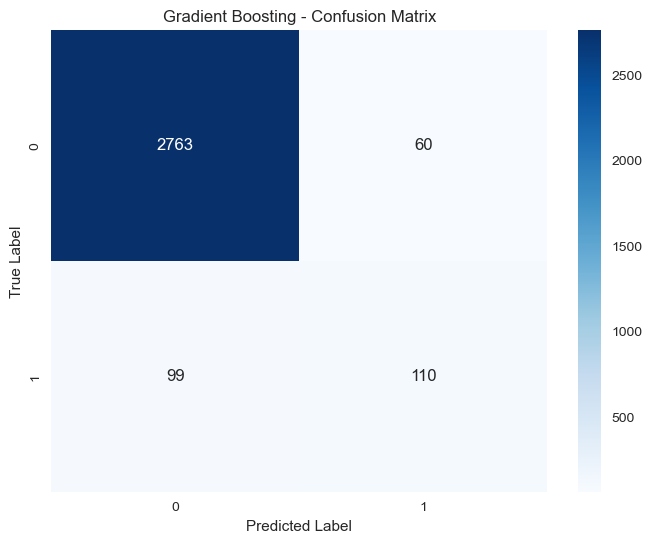


AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.49      0.55       209

    accuracy                           0.94      3032
   macro avg       0.79      0.73      0.76      3032
weighted avg       0.94      0.94      0.94      3032



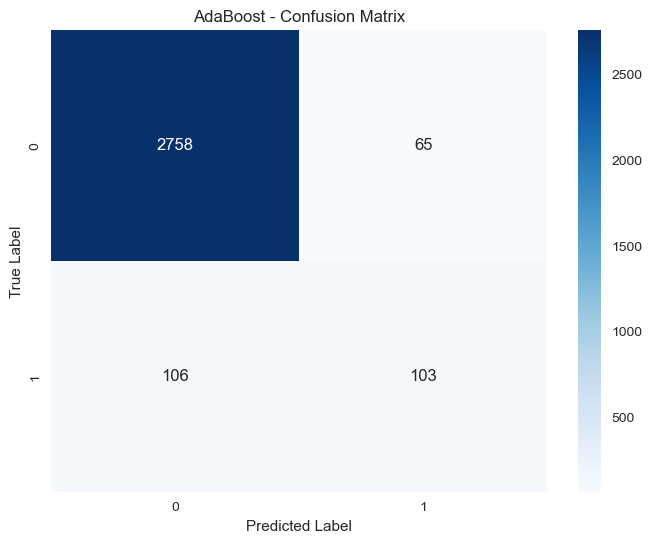

[LightGBM] [Info] Number of positive: 1395, number of negative: 10729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3426
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115061 -> initscore=-2.040056
[LightGBM] [Info] Start training from score -2.040056

LGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.64      0.60      0.62       209

    accuracy                           0.95      3032
   macro avg       0.80      0.79      0.80      3032
weighted avg       0.95      0.95      0.95      3032



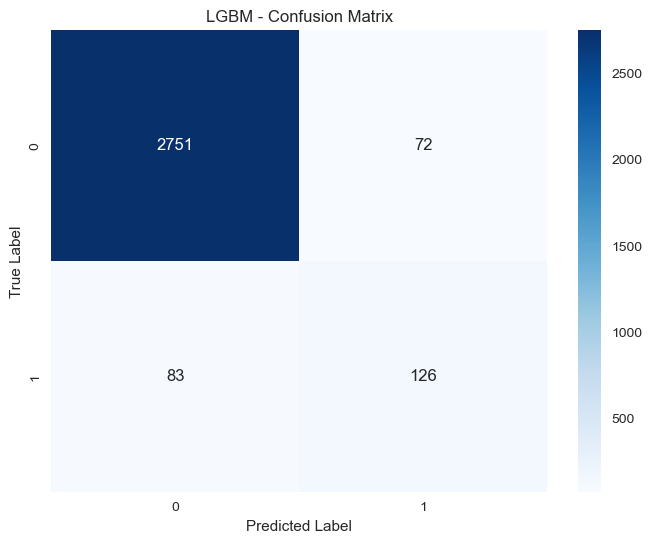

In [610]:
min_max_scaler = MinMaxScaler()
X = data.drop('All_Star', axis=1)
X_scaled = min_max_scaler.fit_transform(X)
y = data['All_Star']

# Train-test split for time series data
train_size = int(0.8 * len(data))  # 80% of the data for training

# Splitting features (X) and target variable (y)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Evaluate each model and plot confusion matrix
for model_name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


After adjusting the hyperparameters, the models do not exhibit improved accuracy; hence, we will retain the default parameters for each model.

### PCA data frame

#### Visualizing the data as it is

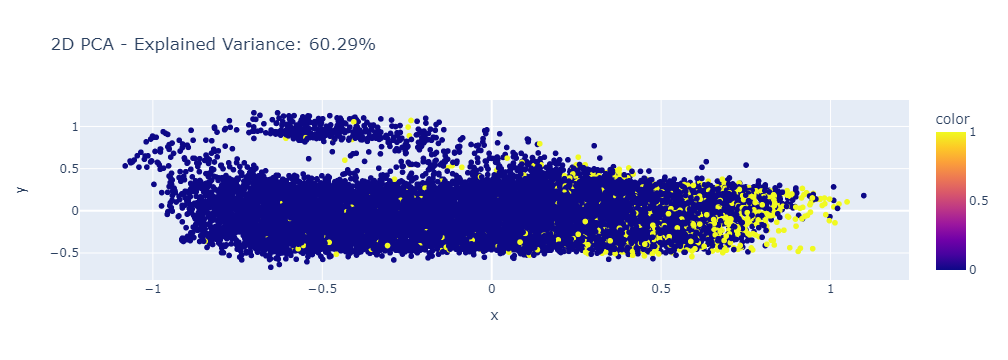

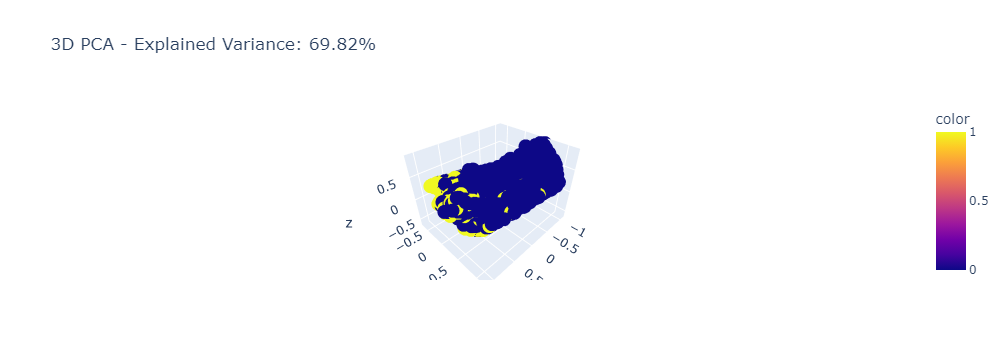

In [612]:
# Perform PCA with different numbers of components
num_components = [2, 3]

results = {}

for n in num_components:
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(X_scaled)
    explained_variance_ratio = sum(pca.explained_variance_ratio_) * 100
    results[n] = {
        'explained_variance_ratio': explained_variance_ratio,
        'principal_components': principal_components
    }

# Visualize the results and compare
for n, result in results.items():
    fig = None
    if n == 2:
        fig = px.scatter(x=result['principal_components'][:, 0], y=result['principal_components'][:, 1], color=data['All_Star'], title=f'2D PCA - Explained Variance: {result["explained_variance_ratio"]:.2f}%')
    elif n == 3:
        fig = px.scatter_3d(x=result['principal_components'][:, 0], y=result['principal_components'][:, 1], z=result['principal_components'][:, 2], color=data['All_Star'], title=f'3D PCA - Explained Variance: {result["explained_variance_ratio"]:.2f}%')
    fig.show()


##### Using PCA with n=3 components allows for the visualization of the data in a three-dimensional space, capturing approximately 60% of the total variance. While this provides an initial insight into the underlying structure of the data, it may not fully capture all the complexities present. Further analysis and exploration using additional components, such as n=7, could reveal more nuanced patterns and relationships. By iteratively adjusting the number of components and examining the resulting variance explained, we can gain a deeper understanding of the dataset's structure and inform subsequent analyses or modeling decisions.

In [613]:
# Define PCA
pca = PCA(n_components=7)

# Fit PCA directly on raw data
principal_components = pca.fit_transform(X_scaled)

# Convert to DataFrame
PCA_df = pd.DataFrame(principal_components)
PCA_df

0         1         2         3         4         5         6
0      0.376688  0.353288 -0.538858 -0.006159  0.055889  0.155086  0.030073
1      0.108428  0.843996 -0.004076  0.204861 -0.125673  0.132707  0.097156
2      0.139693  0.427684 -0.430564  0.066346  0.094362 -0.103954  0.013976
3      0.073163  0.502323 -0.356615  0.063528  0.070245  0.086477  0.113422
4      0.310433  0.350470 -0.537699 -0.052782  0.076315 -0.107893  0.000478
...         ...       ...       ...       ...       ...       ...       ...
15151 -0.102217 -0.433827  0.092129  0.052211  0.073009  0.045223 -0.029594
15152 -0.274098 -0.108461  0.312417 -0.200106 -0.138174  0.073712 -0.116229
15153 -0.152601 -0.410009  0.008147 -0.020282 -0.187585  0.000380  0.123919
15154 -0.696709 -0.001278  0.366091 -0.206763  0.012405  0.045501 -0.023315
15155 -0.782278 -0.214965  0.117149 -0.317099  0.189710 -0.240597 -0.112743

[15156 rows x 7 columns]

In [614]:
# Access the components_
components = pca.components_

# Create a DataFrame to display the components and their corresponding features
components_df = pd.DataFrame(components, columns=X.columns)

# Display the DataFrame
components_df

PLAYER_AGE        GP        GS    FG_PCT   FG3_PCT    FT_PCT       AST  \
0    0.009338  0.611070  0.372890  0.069251  0.060317  0.144669  0.203450   
1   -0.090595 -0.033169 -0.021354 -0.020911 -0.203658 -0.125215 -0.056851   
2   -0.101818 -0.033573  0.346272  0.054086 -0.057700 -0.111283  0.014768   
3    0.118238 -0.248188  0.085597 -0.029786  0.502684  0.649960  0.165325   
4    0.015199 -0.557693  0.457761 -0.054625 -0.041915 -0.404336  0.220945   
5    0.947625 -0.016127  0.091944  0.032315 -0.260973  0.057019 -0.025119   
6    0.231450  0.218872 -0.077967 -0.127475  0.694703 -0.550898  0.083485   

        STL       BLK       TOV        PF      Year   PTS_MIN  OREB_PCT  \
0  0.223229  0.087864  0.277213  0.448072 -0.153984  0.093711 -0.081852   
1 -0.008101  0.026673  0.011733  0.076467 -0.736202 -0.006404  0.435446   
2  0.141676  0.097796  0.178462 -0.048894  0.588886  0.016169  0.468259   
3  0.116875 -0.125368  0.100851 -0.264119 -0.150195  0.195387  0.131358   
4  0.153945  0.031717  0.225746 -0.057156 -0.181423  0.087034 -0.203037   
5 -0.045459  0.050688 -0.030782  0.022997  0.017077 -0.085655  0.056974   
6  0.088107 -0.109831 -0.032606 -0.070831 -0.046726 -0.150211  0.080393   

   DREB_PCT       PER  
0  0.081852  0.188796  
1 -0.435446 -0.037278  
2 -0.468259  0.017008  
3 -0.131358  0.095842  
4  0.203037  0.245533  
5 -0.056974  0.005250  
6 -0.080393 -0.139814

In [615]:
# Variance explained by each component and cumulative variance

print ("Proportion of Variance: \n", pca.explained_variance_ratio_)  
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
print ("\nCumulative Prop. Variance of first 10 components: \n", exp_var_cumul[:10])  

Proportion of Variance: 
 [0.43249148 0.17040228 0.09530875 0.0673525  0.05518432 0.0514697
 0.0399233 ]

Cumulative Prop. Variance of first 10 components: 
 [0.43249148 0.60289377 0.69820252 0.76555502 0.82073934 0.87220904
 0.91213234]


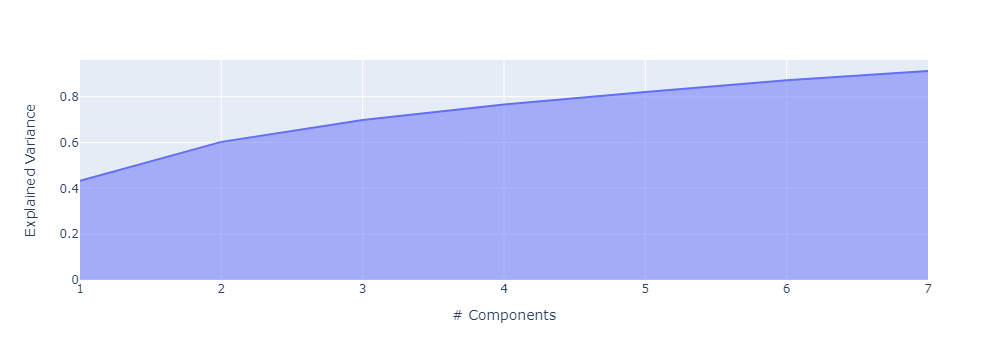

In [616]:
# Plotting cumulative variance

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

#### Conclusion:
##### The cumulative proportion of variance explained by the first seven principal components is approximately 91%. This suggests that these seven components capture a significant portion of the overall variance in the dataset.

### Optimal n for Clustering

#### Silhouette

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 2, the average silhouette_score is : 0.28376840631078204


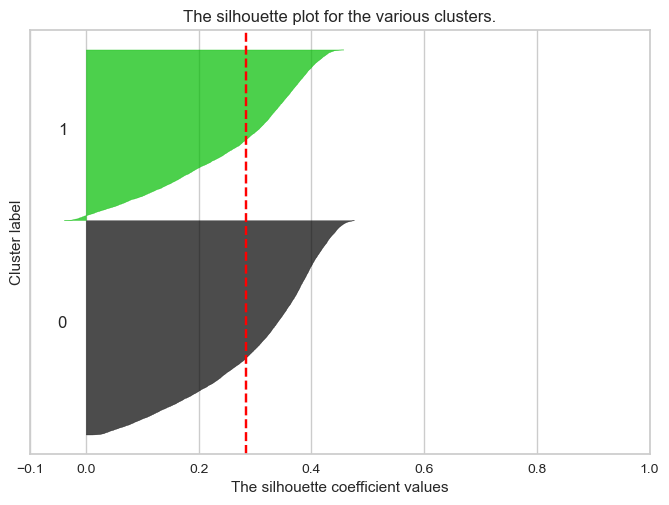

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 3, the average silhouette_score is : 0.19042651156028645


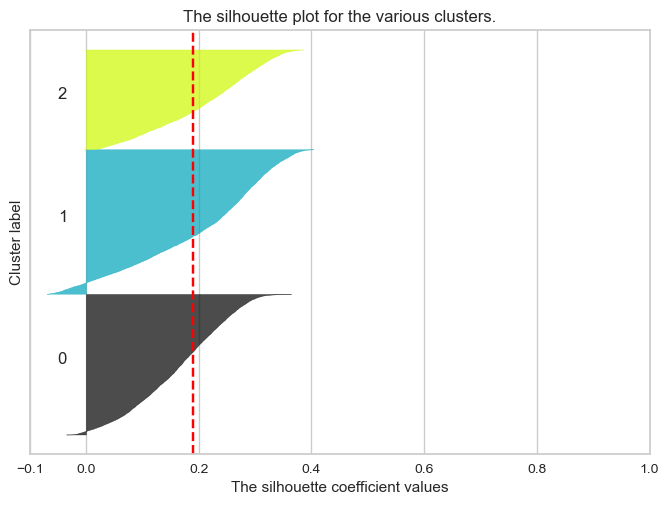

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 4, the average silhouette_score is : 0.21394010388063137


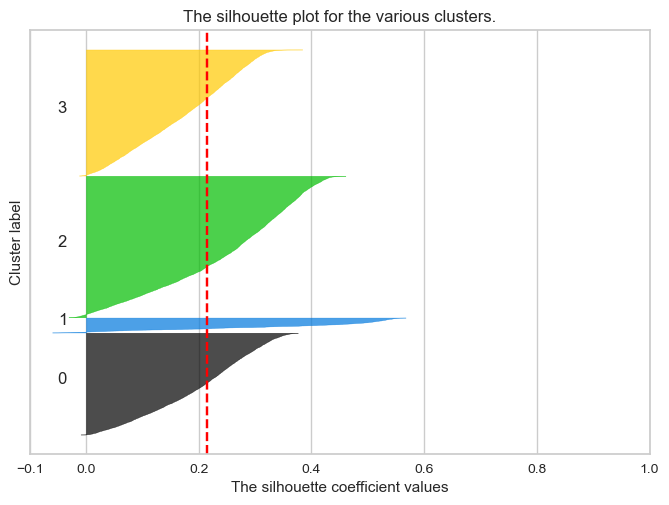

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 5, the average silhouette_score is : 0.20015814819042432


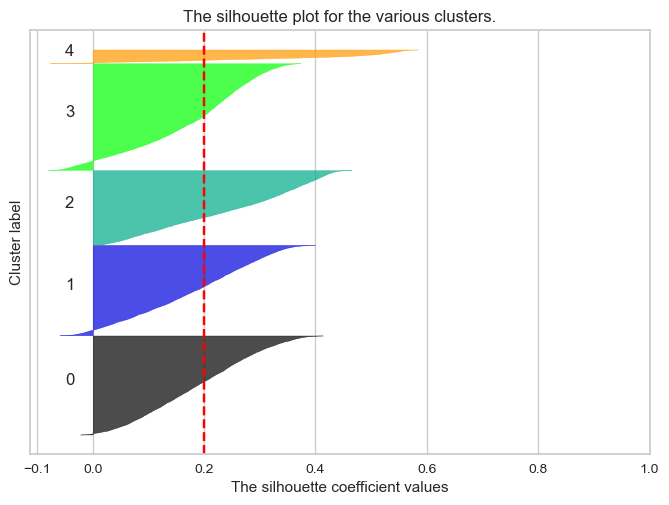

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 6, the average silhouette_score is : 0.18012789460703757


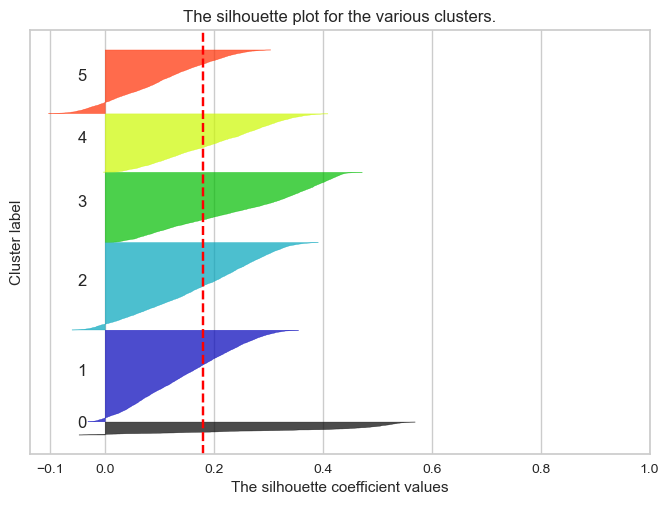

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 7, the average silhouette_score is : 0.1874723749429865


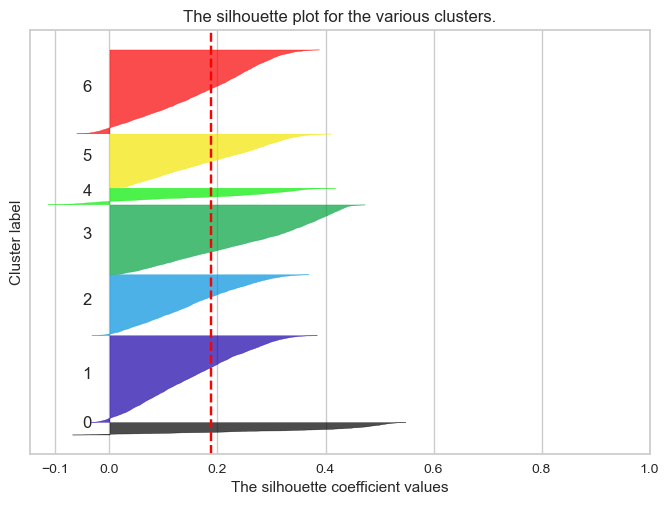

In [617]:
# Create a range of clusters to evaluate
range_n_clusters = [2, 3, 4, 5, 6,7]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

##### The silhouette analysis indicates that dividing the data into two clusters yields the highest average silhouette score (0.242). This score represents a moderate level of separation between the clusters since it is not particularly high. The data points within each cluster exhibit more similarity to each other than to those in other clusters, but we will explore additional methods for determining the optimal value of n.

#### Elbow method

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_i

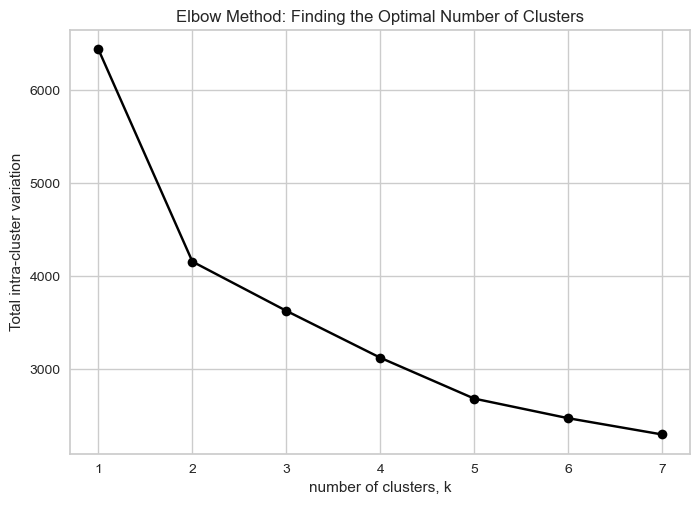

In [618]:
ks = range(1, 8)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.title("Elbow Method: Finding the Optimal Number of Clusters")
plt.xlabel('number of clusters, k')
plt.ylabel('Total intra-cluster variation')
plt.xticks(ks)
plt.show()

##### The optimal n is 2, so we will continue to Kmeans method

#  Models with Clustering

### Kmeans

In [619]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(PCA_df)

C:\Users\liron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(max_iter=50, n_clusters=2)

In [620]:
kmeans_labels = kmeans.labels_
data['Cluster_Id'] = kmeans_labels

In [621]:
data.columns

Index(['PLAYER_AGE', 'GP', 'GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'Year', 'All_Star', 'PTS_MIN', 'OREB_PCT',
       'DREB_PCT', 'PER', 'Cluster_Id'],
      dtype='object')

#### After selecting the optimal number of clusters for use in our model (n=2), we will apply the models we previously ran with the clusters and verify the evaluation metrics and feature weights to ensure if clustering has influenced the model predictions.

In [622]:
min_max_scaler = MinMaxScaler()
X = data.drop('All_Star', axis=1)
X_scaled = min_max_scaler.fit_transform(X)
y = data['All_Star']

# Train-test split for time series data
train_size = int(0.8 * len(data))  # 80% of the data for training

# Splitting features (X) and target variable (y)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the best parameters for each model (replace these with the actual best parameters you found)
models = {}
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost', 'LGBM']:
    if model_name == 'Logistic Regression':
        model = LogisticRegression()
    elif model_name == 'Random Forest':
        model = RandomForestClassifier()
    elif model_name == 'XGBoost':
        model = XGBClassifier()
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier()
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier()
    elif model_name == 'LGBM':
        model = LGBMClassifier()
    
    model.fit(X_train, y_train)
    models[model_name] = model


[LightGBM] [Info] Number of positive: 1395, number of negative: 10729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115061 -> initscore=-2.040056
[LightGBM] [Info] Start training from score -2.040056



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2823
           1       0.70      0.26      0.38       209

    accuracy                           0.94      3032
   macro avg       0.82      0.63      0.67      3032
weighted avg       0.93      0.94      0.93      3032

Logistic Regression - Feature Importances:
PLAYER_AGE: 4.381895279397214
GP: 2.562171005047772
GS: 1.892379250184692
FG_PCT: 1.0072368357363826
FG3_PCT: 0.46391237569606697
FT_PCT: 0.9995963919185336
AST: 2.06588556149248
STL: 0.3247432959874327
BLK: 2.177971810902594
TOV: 0.2080986297284927
PF: 0.6696931142174368
Year: 2.7447505030460344
PTS_MIN: 3.93138959400295
OREB_PCT: 0.5937384690302616
DREB_PCT: 0.5943741609653936
PER: 11.686219120410149
Cluster_Id: 0.857956152889062


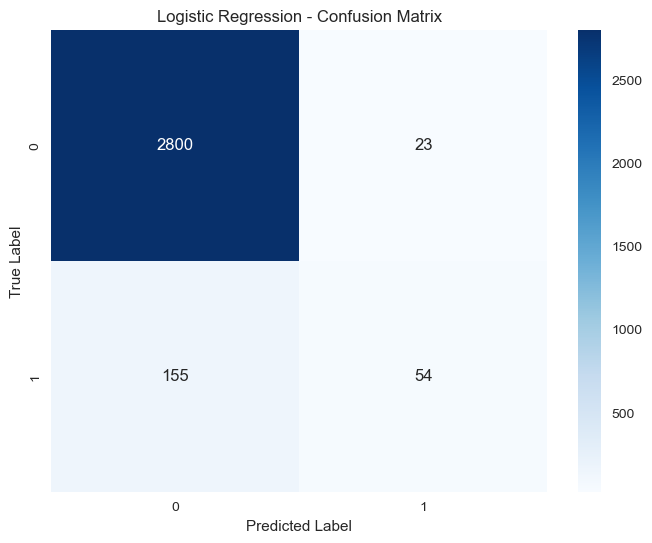


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2823
           1       0.64      0.56      0.60       209

    accuracy                           0.95      3032
   macro avg       0.80      0.77      0.78      3032
weighted avg       0.95      0.95      0.95      3032

Random Forest - Feature Importances:
PLAYER_AGE: 0.06735664786713506
GP: 0.0365497354857907
GS: 0.043319894671459594
FG_PCT: 0.044927754251721234
FG3_PCT: 0.025242241724336832
FT_PCT: 0.0469823901234132
AST: 0.0801803778135704
STL: 0.036653228870406174
BLK: 0.03698191781135311
TOV: 0.04235020020909605
PF: 0.049612702656836996
Year: 0.049581011710476935
PTS_MIN: 0.11580837490770467
OREB_PCT: 0.047560703066266516
DREB_PCT: 0.04643488381592879
PER: 0.22772546859339632
Cluster_Id: 0.002732466421107343


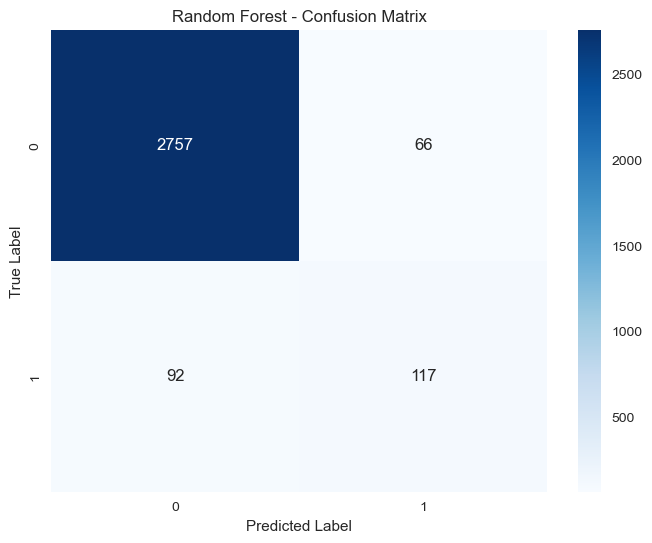


XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.59      0.61      0.60       209

    accuracy                           0.94      3032
   macro avg       0.78      0.79      0.78      3032
weighted avg       0.94      0.94      0.94      3032

XGBoost - Feature Importances:
PLAYER_AGE: 0.09532549977302551
GP: 0.035899922251701355
GS: 0.035350535064935684
FG_PCT: 0.032173193991184235
FG3_PCT: 0.030810603871941566
FT_PCT: 0.037241432815790176
AST: 0.03365122899413109
STL: 0.03361637145280838
BLK: 0.03434545919299126
TOV: 0.03248928114771843
PF: 0.03635662421584129
Year: 0.05701464042067528
PTS_MIN: 0.03418417647480965
OREB_PCT: 0.034562621265649796
DREB_PCT: 0.026897739619016647
PER: 0.4100806713104248
Cluster_Id: 0.0


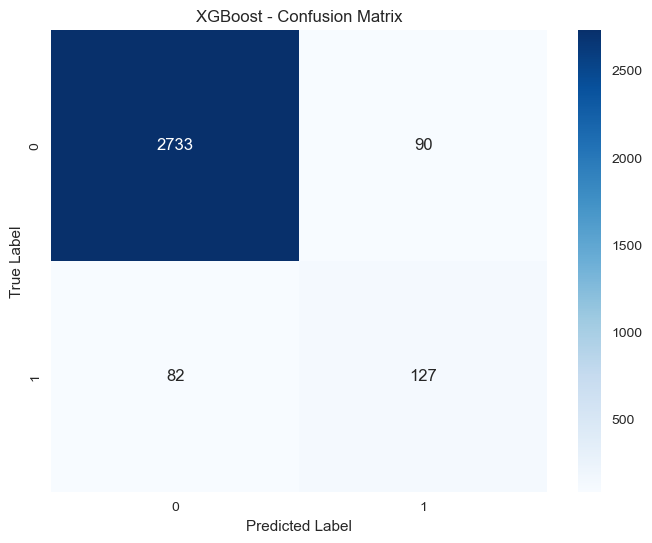


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2823
           1       0.65      0.53      0.58       209

    accuracy                           0.95      3032
   macro avg       0.81      0.75      0.78      3032
weighted avg       0.94      0.95      0.95      3032

Gradient Boosting - Feature Importances:
PLAYER_AGE: 0.114551065786993
GP: 0.004185939918140714
GS: 0.003108144052769387
FG_PCT: 0.005341102274062978
FG3_PCT: 0.004589892638087453
FT_PCT: 0.017997468194406837
AST: 0.024151702545298567
STL: 0.005497042814692159
BLK: 0.00881261090172256
TOV: 0.008618327943011341
PF: 0.013771223151940605
Year: 0.05664172637792839
PTS_MIN: 0.017991337017808143
OREB_PCT: 0.003506191371882065
DREB_PCT: 0.0030849815771112807
PER: 0.7081512434341445
Cluster_Id: 0.0


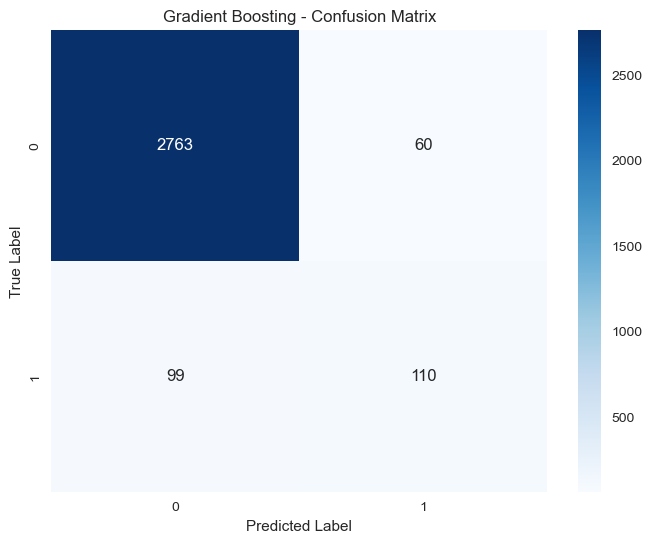


AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.49      0.55       209

    accuracy                           0.94      3032
   macro avg       0.79      0.73      0.76      3032
weighted avg       0.94      0.94      0.94      3032

AdaBoost - Feature Importances:
PLAYER_AGE: 0.14
GP: 0.02
GS: 0.02
FG_PCT: 0.04
FG3_PCT: 0.04
FT_PCT: 0.04
AST: 0.04
STL: 0.0
BLK: 0.04
TOV: 0.0
PF: 0.06
Year: 0.04
PTS_MIN: 0.04
OREB_PCT: 0.02
DREB_PCT: 0.08
PER: 0.38
Cluster_Id: 0.0


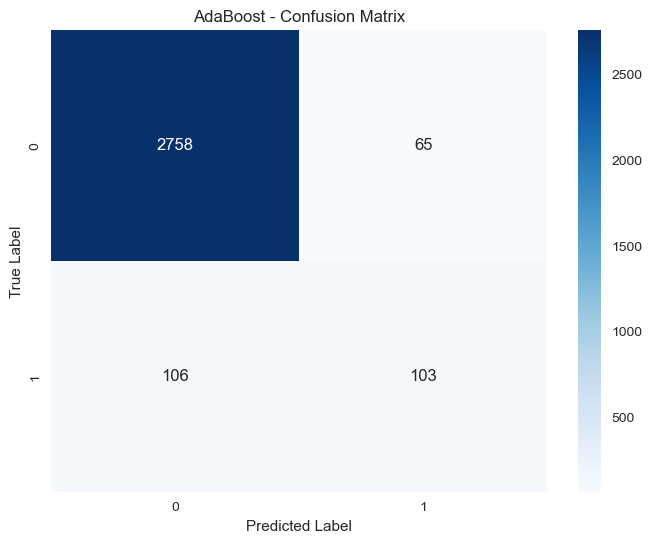


LGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.64      0.60      0.62       209

    accuracy                           0.95      3032
   macro avg       0.80      0.79      0.80      3032
weighted avg       0.95      0.95      0.95      3032

LGBM - Feature Importances:
PLAYER_AGE: 233
GP: 132
GS: 115
FG_PCT: 244
FG3_PCT: 140
FT_PCT: 220
AST: 219
STL: 157
BLK: 178
TOV: 123
PF: 222
Year: 217
PTS_MIN: 240
OREB_PCT: 133
DREB_PCT: 112
PER: 315
Cluster_Id: 0


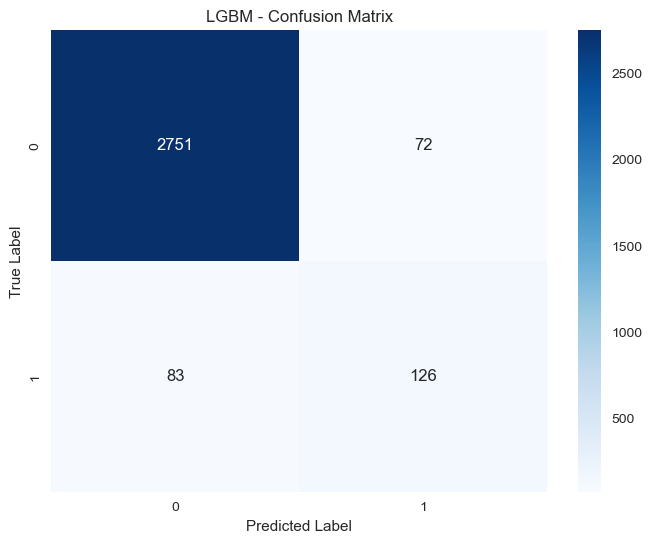

In [623]:
# Evaluate each model and plot confusion matrix
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if hasattr(model, 'feature_importances_') and model_name != 'Logistic Regression':
        print(f"{model_name} - Feature Importances:")
        for feature_name, importance in zip(X.columns, model.feature_importances_):
            print(f"{feature_name}: {importance}")
    elif model_name == 'Logistic Regression':
        print(f"{model_name} - Feature Importances:")
        for feature_name, importance in zip(X.columns, np.abs(model.coef_[0])):
            print(f"{feature_name}: {importance}")
    else:
        print("Feature importances are not available for this model.")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


#### Conclusion
The inclusion of the cluster feature did not significantly impact the performance of the AdaBoost, Gradient Boosting, and LightGBM models. In the logistic regression model, the cluster feature had a minor effect, slightly improving the model's ability to identify All-Star players. However, in the Random Forest and XGBoost models, there was a decline in the accuracy of All-Star predictions.

### Hierarchical cluster

In [624]:
data.columns

Index(['PLAYER_AGE', 'GP', 'GS', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'Year', 'All_Star', 'PTS_MIN', 'OREB_PCT',
       'DREB_PCT', 'PER', 'Cluster_Id'],
      dtype='object')

In [625]:
data.drop(['Cluster_Id'],inplace=True,axis =1)

In [626]:
# Train-test split for time series data
min_max_scaler = MinMaxScaler()
X = data.drop('All_Star', axis=1)
X_scaled = min_max_scaler.fit_transform(X)
y = data['All_Star']

train_size = int(0.8 * len(data))  # 80% of the data for training

# Splitting features (X) and target variable (y)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=2)
hc_labels = hc.fit_predict(X_train)


# Dendrogram Visualization
# plt.figure(figsize=(12, 8))
# dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
# plt.title('Dendrogram')
# plt.xlabel('Data Points')
# plt.ylabel('Euclidean Distances')
# plt.show()


In [628]:
# Initialize and fit models with default parameters

hc_train_labels = hc.fit_predict(X_train).reshape(-1, 1)
hc_test_labels = hc.fit_predict(X_test).reshape(-1, 1)

X_train_with_clusters = np.hstack((X_train, hc_train_labels))
X_test_with_clusters = np.hstack((X_test, hc_test_labels))

models_hr = {}
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost', 'LGBM']:
    if model_name == 'Logistic Regression':
        model = LogisticRegression()
        # Fitting Logistic Regression with Hierarchical Clustering
        model.fit(X_train_with_clusters, y_train)  # Fit the model with the clustered features
        coefficients_lr_with_clusters = model.coef_[0]  # Access coefficients
    elif model_name == 'Random Forest':
        model = RandomForestClassifier()
        model.fit(X_train_with_clusters, y_train)  # Fit RandomForestClassifier
        feature_importances_rf_with_clusters = model.feature_importances_
    elif model_name == 'XGBoost':
        model = XGBClassifier()
        model.fit(X_train_with_clusters, y_train)  # Fit XGBClassifier
        feature_importances_xgb_with_clusters = model.feature_importances_
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier()
        model.fit(X_train_with_clusters, y_train)  # Fit GradientBoostingClassifier
        feature_importances_gb_with_clusters = model.feature_importances_
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier()
        model.fit(X_train_with_clusters, y_train)  # Fit AdaBoostClassifier
        feature_importances_adaboost_with_clusters = model.feature_importances_
    elif model_name == 'LGBM':
        model = LGBMClassifier()
        model.fit(X_train_with_clusters, y_train)  # Fit LGBMClassifier
        feature_importances_lgbm_with_clusters = model.feature_importances_
    else:
        continue
    models_hr[model_name] = model
    feature_names_with_clusters = list(X.columns) + ['Cluster_Labels']


[LightGBM] [Info] Number of positive: 1395, number of negative: 10729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 12124, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115061 -> initscore=-2.040056
[LightGBM] [Info] Start training from score -2.040056



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2823
           1       0.70      0.25      0.37       209

    accuracy                           0.94      3032
   macro avg       0.82      0.62      0.67      3032
weighted avg       0.93      0.94      0.93      3032

Logistic Regression - Feature Importances:
PLAYER_AGE: 4.394850535776265
GP: 2.257712477625897
GS: 1.9613925217630126
FG_PCT: 1.0488051034017911
FG3_PCT: 0.4929169099147345
FT_PCT: 1.062969415538657
AST: 2.0989314274716793
STL: 0.34028346217385325
BLK: 2.1880701892588843
TOV: 0.2127414975073331
PF: 0.5857715684545228
Year: 2.7667140584055483
PTS_MIN: 3.9972046231124527
OREB_PCT: 0.6382839176683603
DREB_PCT: 0.6451968430266682
PER: 11.71871519400149
Cluster_Labels: 0.6446250684602466


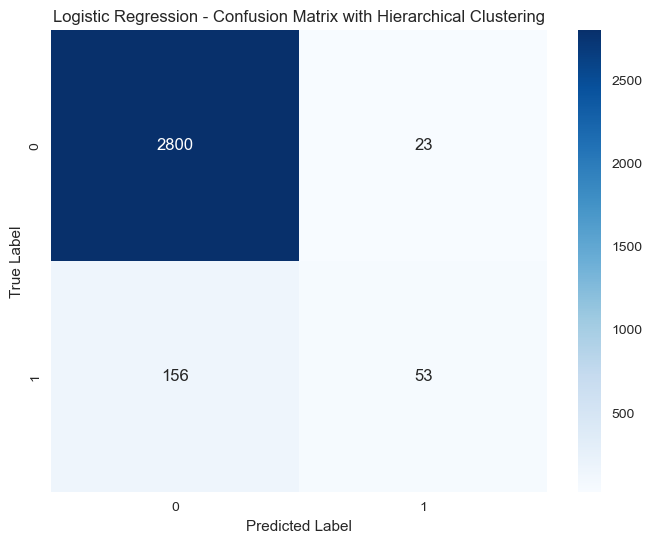


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.52      0.56       209

    accuracy                           0.94      3032
   macro avg       0.79      0.75      0.77      3032
weighted avg       0.94      0.94      0.94      3032

Random Forest - Feature Importances:
PLAYER_AGE: 0.06676618427796259
GP: 0.03626221165738072
GS: 0.04784680231538216
FG_PCT: 0.046305753597758036
FG3_PCT: 0.02407525162332793
FT_PCT: 0.04806250847403508
AST: 0.07279675774749665
STL: 0.03600069782708967
BLK: 0.038721492651042036
TOV: 0.048622137776545934
PF: 0.048881254164567754
Year: 0.048895966379435184
PTS_MIN: 0.10656200432900018
OREB_PCT: 0.04646613234902037
DREB_PCT: 0.04663973196943025
PER: 0.23534935273184987
Cluster_Labels: 0.001745760128675592


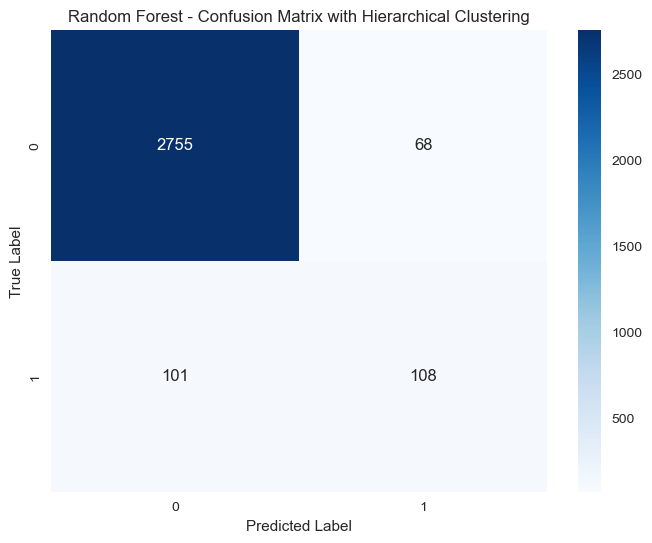


XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.59      0.61      0.60       209

    accuracy                           0.94      3032
   macro avg       0.78      0.79      0.78      3032
weighted avg       0.94      0.94      0.94      3032

XGBoost - Feature Importances:
PLAYER_AGE: 0.09319543838500977
GP: 0.035187214612960815
GS: 0.034561049193143845
FG_PCT: 0.03145425394177437
FG3_PCT: 0.030122047290205956
FT_PCT: 0.036409370601177216
AST: 0.03289928659796715
STL: 0.032865844666957855
BLK: 0.03357827663421631
TOV: 0.03176332265138626
PF: 0.035544268786907196
Year: 0.05574049800634384
PTS_MIN: 0.03341998904943466
OREB_PCT: 0.033790577203035355
DREB_PCT: 0.026296714320778847
PER: 0.40091755986213684
Cluster_Labels: 0.02225431799888611


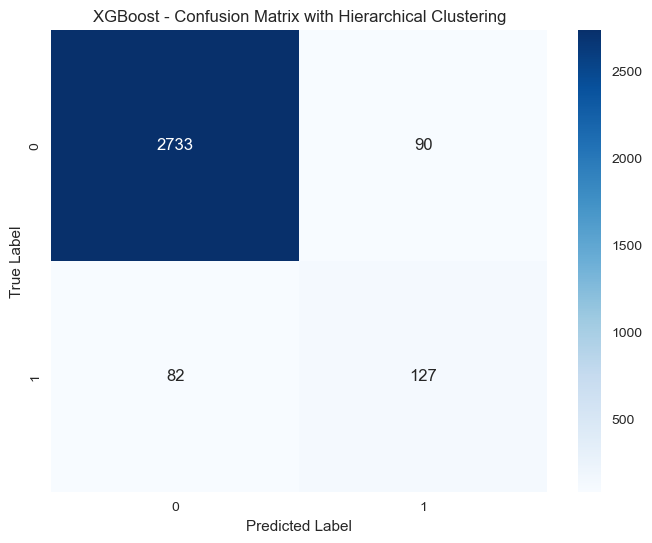


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2823
           1       0.65      0.53      0.58       209

    accuracy                           0.95      3032
   macro avg       0.81      0.75      0.78      3032
weighted avg       0.94      0.95      0.95      3032

Gradient Boosting - Feature Importances:
PLAYER_AGE: 0.11453791051580668
GP: 0.004242679535095782
GS: 0.0031492127322296126
FG_PCT: 0.0053589527810924496
FG3_PCT: 0.0045586703536915065
FT_PCT: 0.01807410174257874
AST: 0.02415170254530368
STL: 0.0053903568170191015
BLK: 0.008812610901727204
TOV: 0.008675587224931842
PF: 0.013719192737373721
Year: 0.05664052949366978
PTS_MIN: 0.017978827907482575
OREB_PCT: 0.004226877359400617
DREB_PCT: 0.0022627699580559176
PER: 0.7082200173945409
Cluster_Labels: 0.0


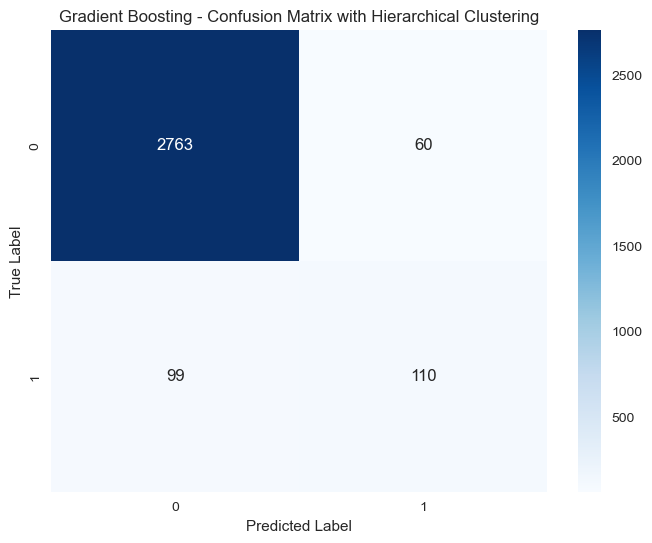


AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2823
           1       0.61      0.49      0.55       209

    accuracy                           0.94      3032
   macro avg       0.79      0.73      0.76      3032
weighted avg       0.94      0.94      0.94      3032

AdaBoost - Feature Importances:
PLAYER_AGE: 0.14
GP: 0.02
GS: 0.02
FG_PCT: 0.04
FG3_PCT: 0.04
FT_PCT: 0.04
AST: 0.04
STL: 0.0
BLK: 0.04
TOV: 0.0
PF: 0.06
Year: 0.04
PTS_MIN: 0.04
OREB_PCT: 0.02
DREB_PCT: 0.08
PER: 0.38
Cluster_Labels: 0.0


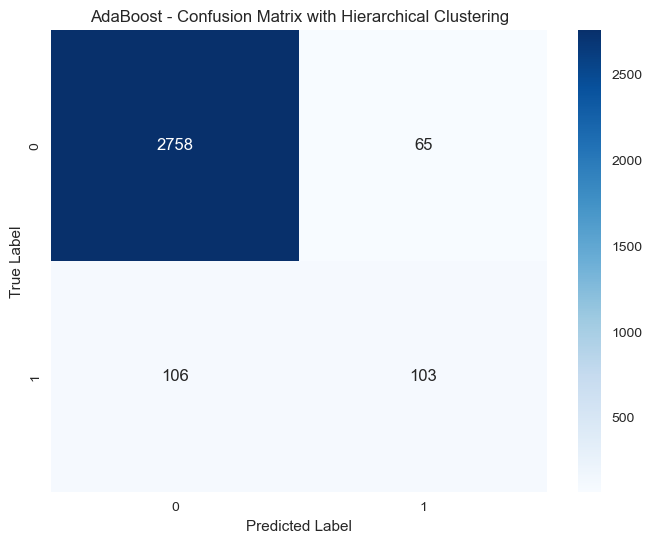


LGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2823
           1       0.64      0.60      0.62       209

    accuracy                           0.95      3032
   macro avg       0.80      0.79      0.80      3032
weighted avg       0.95      0.95      0.95      3032

LGBM - Feature Importances:
PLAYER_AGE: 233
GP: 132
GS: 115
FG_PCT: 244
FG3_PCT: 140
FT_PCT: 220
AST: 219
STL: 157
BLK: 178
TOV: 123
PF: 222
Year: 217
PTS_MIN: 240
OREB_PCT: 133
DREB_PCT: 112
PER: 315
Cluster_Labels: 0


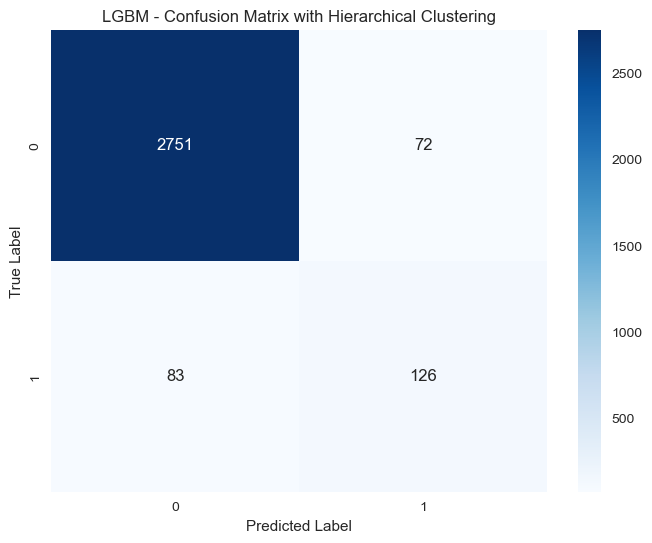

In [629]:
feature_names_dict = {
    'Logistic Regression': feature_names_with_clusters,
    'Random Forest': feature_names_with_clusters,  
    'XGBoost': feature_names_with_clusters,
    'Gradient Boosting': feature_names_with_clusters, 
    'AdaBoost': feature_names_with_clusters,  
    'LGBM': feature_names_with_clusters  
}

# Evaluate each model and plot confusion matrix
for model_name, model in models_hr.items():
    y_pred = model.predict(X_test_with_clusters)
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if hasattr(model, 'feature_importances_') and model_name != 'Logistic Regression':
        print(f"{model_name} - Feature Importances:")
        for feature_name, importance in zip(feature_names_dict[model_name], model.feature_importances_):
            print(f"{feature_name}: {importance}")
    elif model_name == 'Logistic Regression':
        print(f"{model_name} - Feature Importances:")
        for feature_name, importance in zip(feature_names_dict[model_name], np.abs(coefficients_lr_with_clusters)):
            print(f"{feature_name}: {importance}")
    else:
        print("Feature importances are not available for this model.")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.title(f'{model_name} - Confusion Matrix with Hierarchical Clustering')
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#### Conclutions:
The trend remains largely consistent with the addition of the reference model, albeit with slight changes.

In logistic regression, there is no improvement in the data.

In XGBoost, Random Forest, and AdaBoost, there is a slightly larger improvement compared to the reference test.

However, in Gradient Boosting and LGBM, there is a slight degradation from the reference test.